#### 增加round check

In [7]:
import numpy as np
import logging
from scipy.special import softmax
import time
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import os


# 配置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ================== Utility Functions ==================
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))

def jain_fairness(x):
    """Improved Jain Index Calculation (Standard version)"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x)**2) / (len(x)*np.sum(x**2) + 1e-8)

def gini(x):
    """Gini coefficient calculation"""
    x = np.sort(x)
    n = len(x)
    return (np.sum((2 * np.arange(1, n+1) - n - 1) * x)) / (n * np.sum(x) + 1e-8)

def simulate_tau_i(C_i_t, base_time=15.0, noise_scale=5.0):
    """Optimized training time simulation with symmetric noise"""
    adjusted_time = base_time / (1 + C_i_t/40)  # Smoother decay curve
    noise = np.random.normal(0, noise_scale)     # Symmetric noise
    tau_i = max(adjusted_time + noise, 1e-6)     # Ensure positive value
    return tau_i

# ================== Node Class ==================
class Node:
    """Enhanced Federated Learning Node with Security Features"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.contrib_history = []
        self.cooldown = 0
        self.last_violation_round = -np.inf
        self.consecutive_committee = 0
        self.total_committee = 0
        self.local_training_time = 0.0
        self.identity_verified = True
        self.sybil_count = 0  # For sybil resistance

    def update_committee_status(self, is_in_committee):
        """Improved committee cooldown management"""
        if is_in_committee and self.cooldown <= 0:
            self.consecutive_committee += 1
            self.total_committee += 1
            self.cooldown = 2 + int(np.sqrt(self.consecutive_committee))  # Dynamic cooldown
        elif is_in_committee:
            logger.debug(f"Node {self.id} cooldown blocked: {self.cooldown} remaining")
        
        if not is_in_committee:
            self.consecutive_committee = 0
        
        self.cooldown = max(0, self.cooldown - 1)

    def act_normal(self):
        """Realistic normal behavior with contextual variation"""
        base = np.random.normal(7, 1.5)
        fluctuation = 0.9 + 0.2 * np.sin(self.participation/10)  # Periodic variation
        contrib = max(0, base * fluctuation)
        self.contrib_history.append(contrib)
        return contrib

    def act_malicious(self, phase):
        """Advanced adaptive attack patterns"""
        try:
            if phase == 1:  # Stealth attack
                if np.random.rand() < 0.8:
                    contrib = np.clip(np.random.normal(7.5, 1.2), 6, 9)
                else:
                    contrib = 0
            elif phase == 2:  # Oscillation attack
                contrib = 8 + 2 * np.sin(self.participation/2)
            elif phase == 3:  # Strategic zero attack
                contrib = 0 if self.participation % 3 == 0 else np.random.normal(7, 1)
            else:
                contrib = np.random.normal(6, 2)
        except Exception as e:
            logger.error(f"Attack error: {str(e)}")
            contrib = np.random.normal(6, 1)
        
        self.contrib_history.append(max(contrib, 0))
        return contrib

# ================== FLSystem Class ==================
class FLSystem:
    """Optimized Federated Learning System with Enhanced Security"""
    def __init__(self, 
                 num_nodes=100,
                 base_reward=1500,
                 committee_size=15,
                 stake_weight=0.35,
                 rep_exponent=0.7,
                 init_stake=100,
                 init_rep=100,
                 malicious_ratio=0.15,
                 phase_switch_round=30):
        
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        self.malicious_nodes = self._init_malicious_nodes(malicious_ratio)
        self.base_reward = base_reward
        self.committee_size = committee_size
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.phase_switch_round = phase_switch_round
        
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []
        self.gini_history = []
        self.fairness_history = []
        self.detection_history = []
        self.committee_history = []
        self.penalty_history = []

    def _init_malicious_nodes(self, ratio):
        num_malicious = int(len(self.nodes) * ratio)
        return self.nodes[:num_malicious]

    def _dynamic_malicious_threshold(self):
        contribs = [n.contrib_history[-1] if n.contrib_history else 0 for n in self.nodes]
        moving_avg = np.mean(contribs[-10:]) if len(contribs) >=10 else np.mean(contribs)
        return max(0.5 * moving_avg, 3.0)

    def select_committee(self, num_strata=4):
        """Quantile-based stratified sampling"""
        sorted_nodes = sorted(self.nodes, key=lambda x: x.reputation, reverse=True)
        
        # Quantile-based stratification
        strata = np.array_split(sorted_nodes, num_strata)
        selected = []
        remaining_quota = self.committee_size
        
        # First pass: proportional selection
        for stratum in strata:
            quota = min(remaining_quota // num_strata, len(stratum))
            candidates = [n for n in stratum if n.cooldown <= 0]
            
            if candidates:
                reputations = np.array([n.reputation for n in candidates])
                probs = softmax(np.sqrt(reputations))  # Smoother probability distribution
                selected_nodes = np.random.choice(candidates, size=min(quota, len(candidates)), 
                                                 p=probs, replace=False)
                selected.extend(selected_nodes)
                remaining_quota -= len(selected_nodes)
        
        # Second pass: fill remaining quota
        if remaining_quota > 0:
            candidates = [n for n in self.nodes if n.cooldown <=0 and n not in selected]
            if candidates:
                reputations = np.array([n.reputation for n in candidates])
                probs = softmax(np.sqrt(reputations))
                selected_nodes = np.random.choice(candidates, size=remaining_quota, 
                                                 p=probs, replace=False)
                selected.extend(selected_nodes)
        
        # Update node states
        for node in self.nodes:
            node.update_committee_status(node in selected)
        
        self.committee_history.append([n.id for n in selected])
        return selected

    def calculate_reward(self, node, avg_rep):
        """Hybrid Reward Calculation with Sybil Resistance"""
        if not node.contrib_history or node.contrib_history[-1] == 0:
            return 0.0
        
        # Sybil-resistant stake calculation
        effective_stake = node.stake / (1 + node.sybil_count**0.5)
        
        # Contribution calculation
        hist_contrib = sum(c * (0.85**t) for t, c in enumerate(reversed(node.contrib_history[-5:])))
        total_hist = sum(sum(c * (0.85**t) for t, c in enumerate(reversed(n.contrib_history[-5:]))) 
                        for n in self.nodes) + 1e-8
        
        # Dynamic weights
        alpha = sigmoid((avg_rep - 100)/40) * self.stake_weight
        beta = 1 - alpha
        
        # Fairness components
        diversity_bonus = jain_fairness([n.reputation for n in self.nodes])
        committee_bonus = 50 * diversity_bonus if node.id in self.committee_history[-1] else 0
        
        # Final calculation
        base = (alpha * self.base_reward * (effective_stake / (sum(n.stake for n in self.nodes) + 1e-8)) +
               beta * self.base_reward * (hist_contrib / total_hist))
        total = base * (0.6 + 0.4*diversity_bonus) + committee_bonus
        
        return min(max(total, 0), 800)  # Reward cap at 800

    def update_reputation(self, node, contribution):
        """Enhanced Reputation System with Dynamic Decay"""
        age_factor = 1 - 1/(1 + node.participation/80)
        delta = 0.72 + 0.18 * age_factor  # More aggressive decay
        
        # Contribution quality calculation
        X_c = 60
        C_max = 80
        C_i_t = max(contribution, 0)
        tau_i = simulate_tau_i(C_i_t)
        
        quality = (X_c * C_i_t / tau_i) * (1 - np.exp(-C_i_t/C_max))
        
        # Stability factor
        window_size = 15
        if len(node.contrib_history) >= window_size:
            stability = 1 - np.std(node.contrib_history[-window_size:])/6
        else:
            stability = 0.6 - 0.1*window_size
        
        new_rep = node.reputation * delta + quality * 45 + stability * 25
        rep_cap = 400 + 3 * self.current_round
        return np.clip(new_rep, -150, rep_cap)

    def detect_malicious(self, node):
        """Context-Aware Malicious Detection"""
        if len(node.contrib_history) < 5:
            return False
        
        # Statistical analysis
        window = node.contrib_history[-5:]
        avg = np.mean(window)
        std = np.std(window)
        
        # Contextual thresholds
        global_contribs = [n.contrib_history[-1] for n in self.nodes if n.contrib_history]
        global_avg = np.mean(global_contribs)
        global_std = np.std(global_contribs) + 1e-8
        
        # Dynamic conditions
        cond1 = avg < 0.6*self._dynamic_malicious_threshold() and std < 2.0
        cond2 = abs(avg - np.mean(node.contrib_history[-10:-5])) > 6
        cond3 = (node.contrib_history[-1] > global_avg + 2.5*global_std and
                np.mean(node.contrib_history[-3:]) > 1.8*np.mean(node.contrib_history[-6:-3]))
        
        return cond1 or cond2 or cond3

    def run_round(self):
        """Execute full simulation round"""
        # Phase calculation
        base_phase = 1 + int(self.current_round / self.phase_switch_round)
        attack_phase = min(base_phase + (self.current_round % 3), 3)
        
        # Node contributions
        contributions = []
        for node in self.nodes:
            if node in self.malicious_nodes:
                contrib = node.act_malicious(attack_phase)
            else:
                contrib = node.act_normal()
            contributions.append(contrib)
        
        # Committee selection
        committee = self.select_committee()
        
        # System updates
        avg_rep = np.mean([n.reputation for n in self.nodes])
        rewards = []
        penalties = []
        detected = 0
        
        for node, contrib in zip(self.nodes, contributions):
            if self.detect_malicious(node):
                penalty = min(0.25*node.reputation + 0.15*node.stake, node.reputation*0.6)
                node.reputation -= penalty
                node.violations += 1
                detected += 1
                penalties.append(penalty)
            else:
                node.reputation = self.update_reputation(node, contrib)
            
            reward = self.calculate_reward(node, avg_rep)
            node.total_reward += reward
            rewards.append(reward)
            node.participation += 1

        # Record metrics
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.gini_history.append(gini(rewards))
        self.fairness_history.append(jain_fairness(rewards))
        self.detection_history.append(detected)
        self.penalty_history.append(penalties)
        self.current_round += 1

        logger.info(f"Round {self.current_round} completed. Detected {detected} malicious nodes.")
        return self

开始运行包含恶意节点的模拟...


包含恶意节点:   0%|          | 0/80 [00:00<?, ?it/s]INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 4 completed. Detect


开始运行不包含恶意节点的模拟...


不包含恶意节点:   0%|          | 0/80 [00:00<?, ?it/s]INFO:__main__:Round 1 completed. Detected 0 malicious nodes.
INFO:__main__:Round 2 completed. Detected 0 malicious nodes.
INFO:__main__:Round 3 completed. Detected 0 malicious nodes.
INFO:__main__:Round 4 completed. Detected 0 malicious nodes.
INFO:__main__:Round 5 completed. Detected 0 malicious nodes.
INFO:__main__:Round 6 completed. Detected 0 malicious nodes.
INFO:__main__:Round 7 completed. Detected 0 malicious nodes.
INFO:__main__:Round 8 completed. Detected 0 malicious nodes.
INFO:__main__:Round 9 completed. Detected 0 malicious nodes.
INFO:__main__:Round 10 completed. Detected 0 malicious nodes.
INFO:__main__:Round 11 completed. Detected 0 malicious nodes.
INFO:__main__:Round 12 completed. Detected 0 malicious nodes.
INFO:__main__:Round 13 completed. Detected 0 malicious nodes.
INFO:__main__:Round 14 completed. Detected 0 malicious nodes.
不包含恶意节点:  18%|█▊        | 14/80 [00:00<00:00, 136.04it/s]INFO:__main__:Round 15 completed. Det


生成模拟报告...
Round metrics saved to simulation_report_with_malicious_0p10_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p10_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p15_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p15_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p20_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p20_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p25_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p25_node_summary.csv
Round metrics saved to simulation_report_with_malicious_0p30_round_metrics.csv
Node summary metrics saved to simulation_report_with_malicious_0p30_node_summary.csv
Round metrics saved to simulation_report_without_malicious_round_metrics.csv
Node summary metrics saved to simulation_report_without_malicious_node_summary.csv

验证所有系统的委

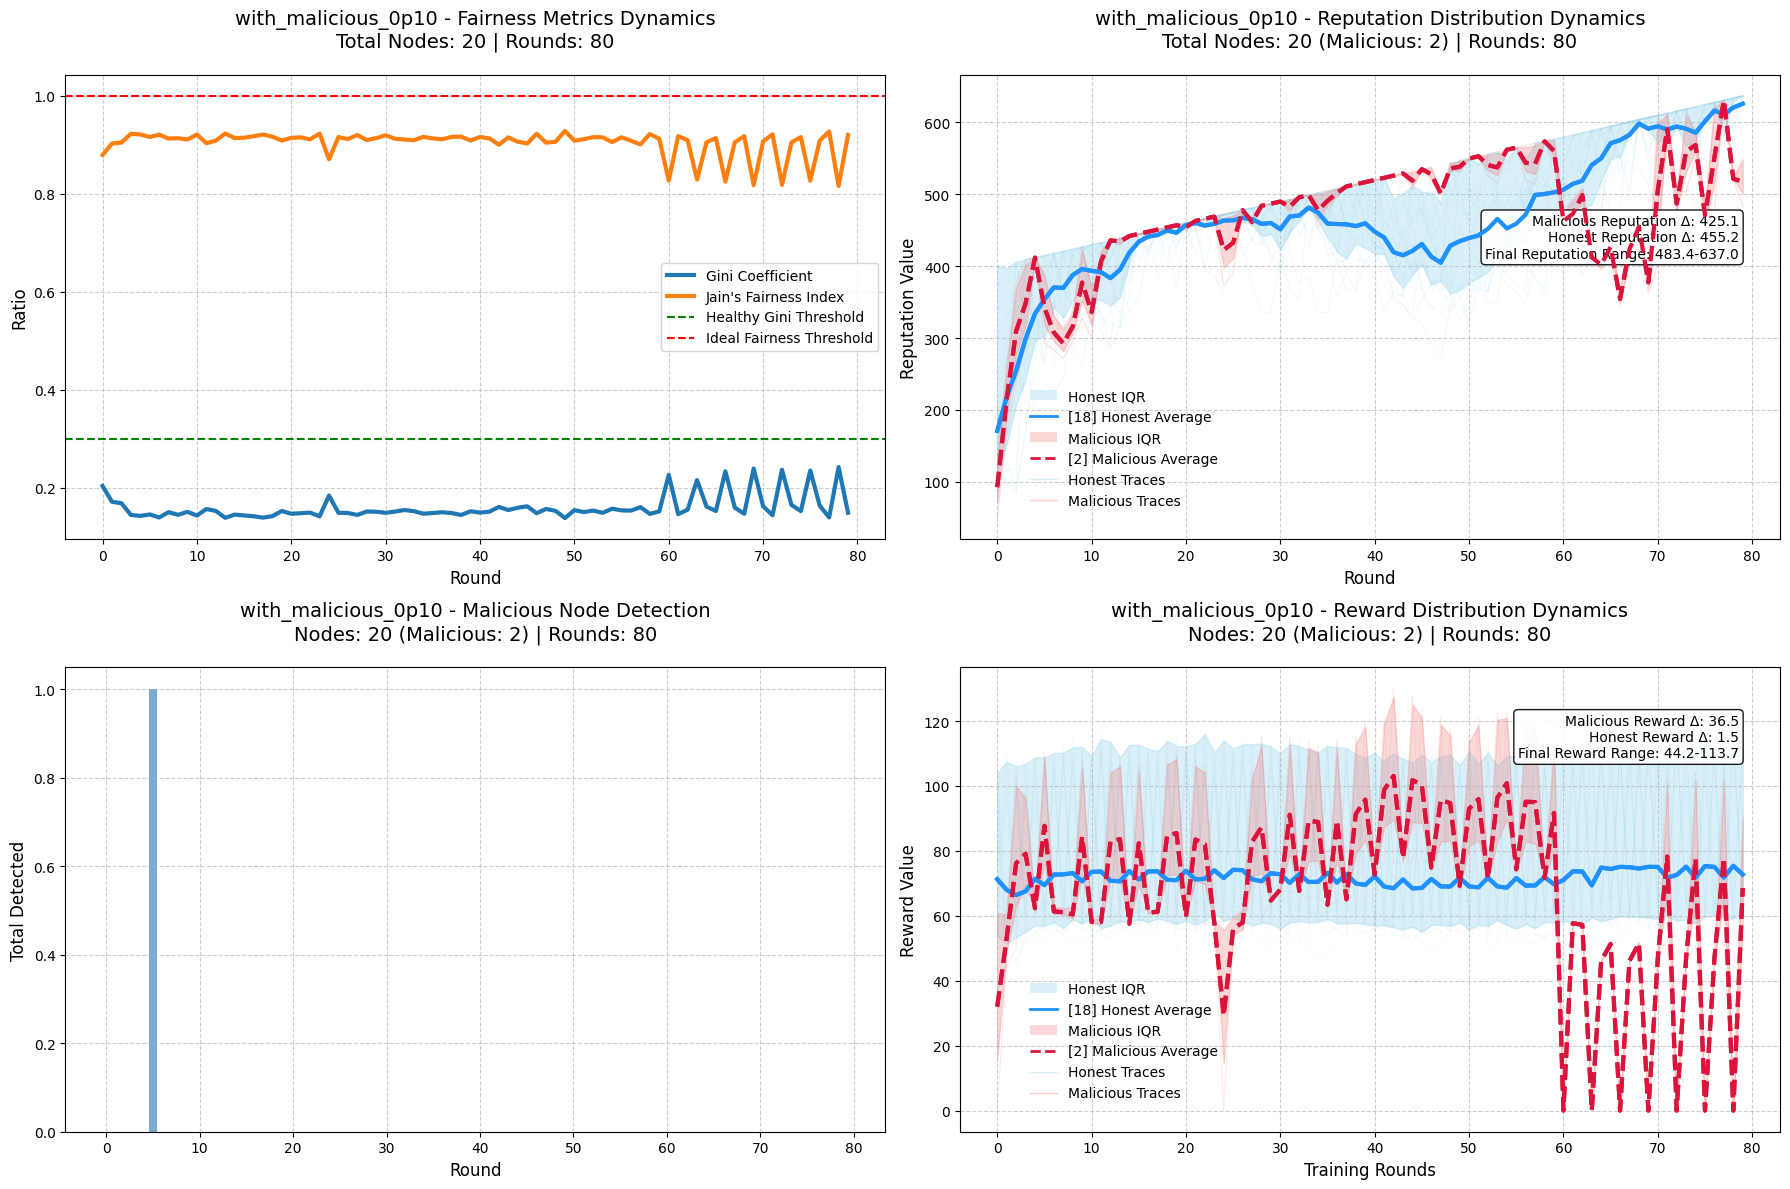

with_malicious_0p15
生成系统 'with_malicious_0p15' 的图表...


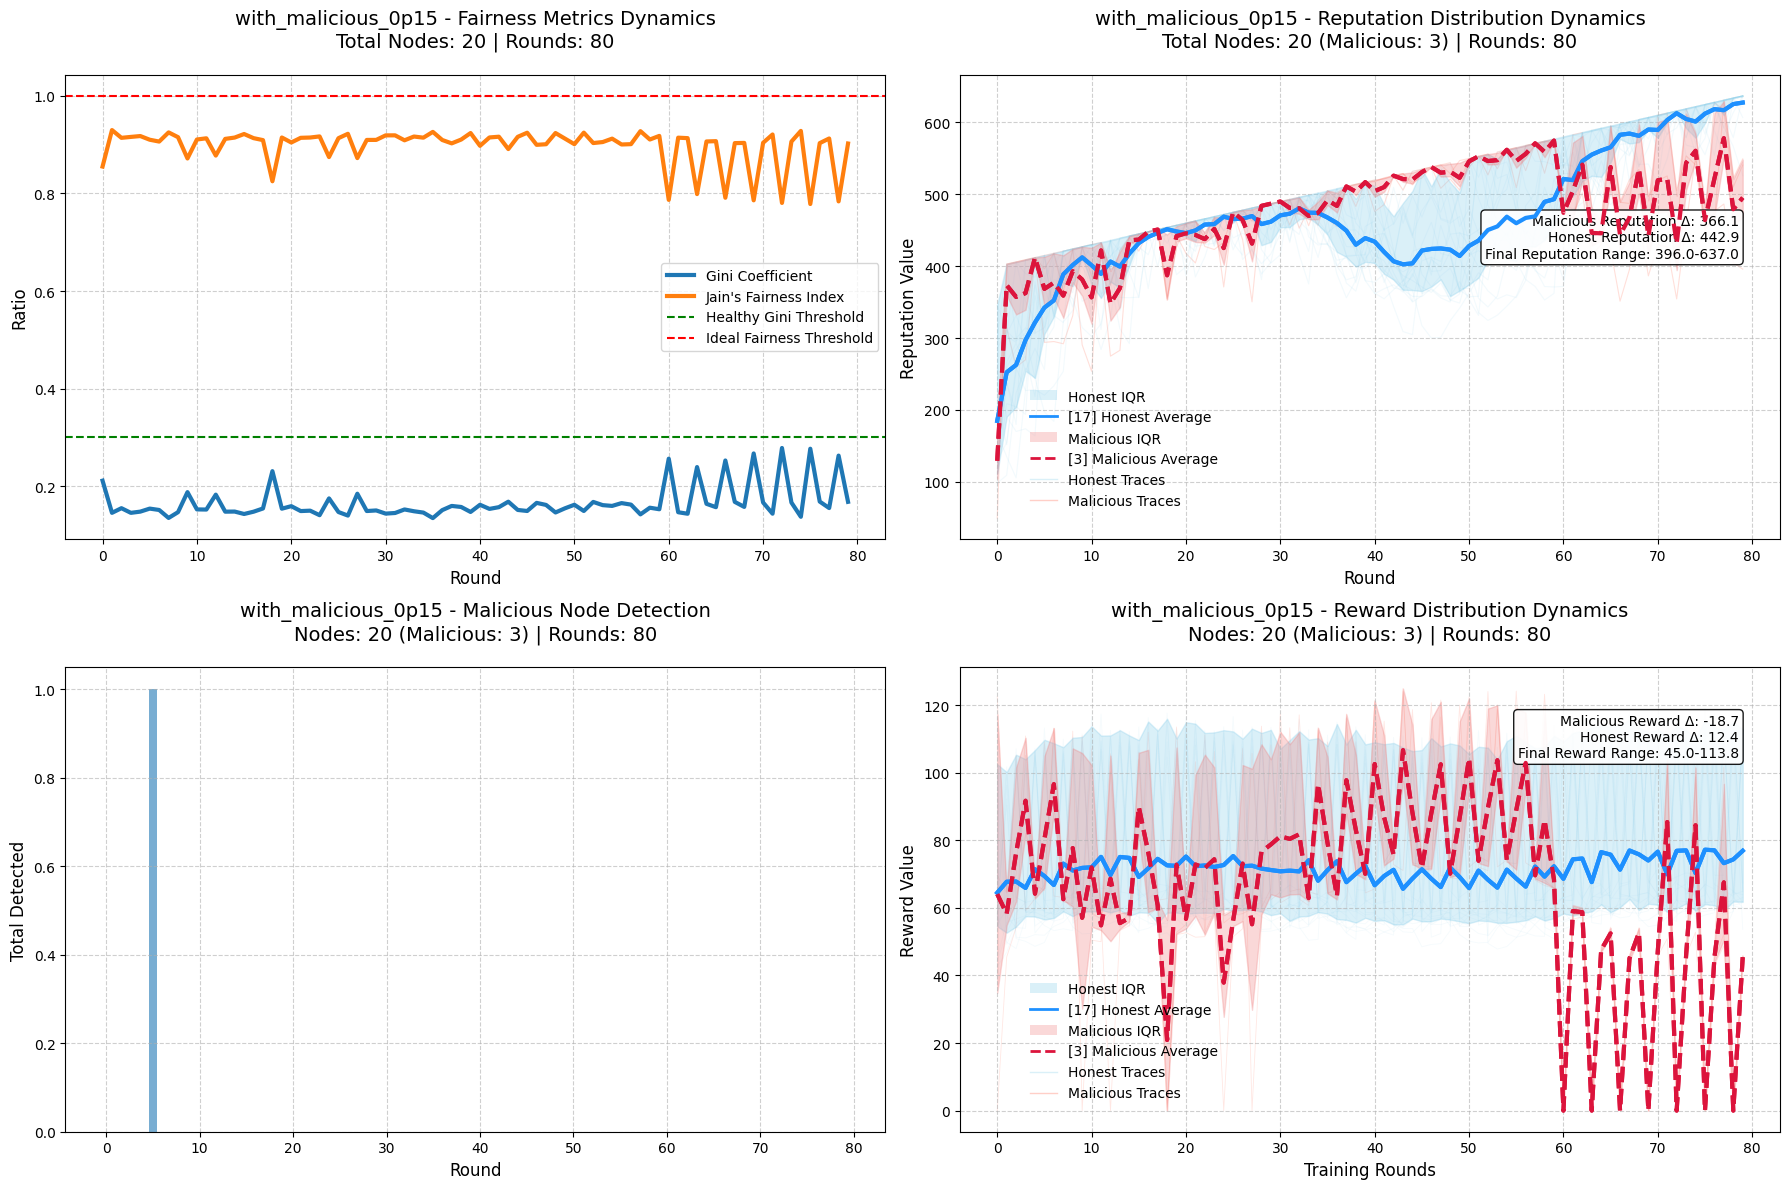

with_malicious_0p20
生成系统 'with_malicious_0p20' 的图表...


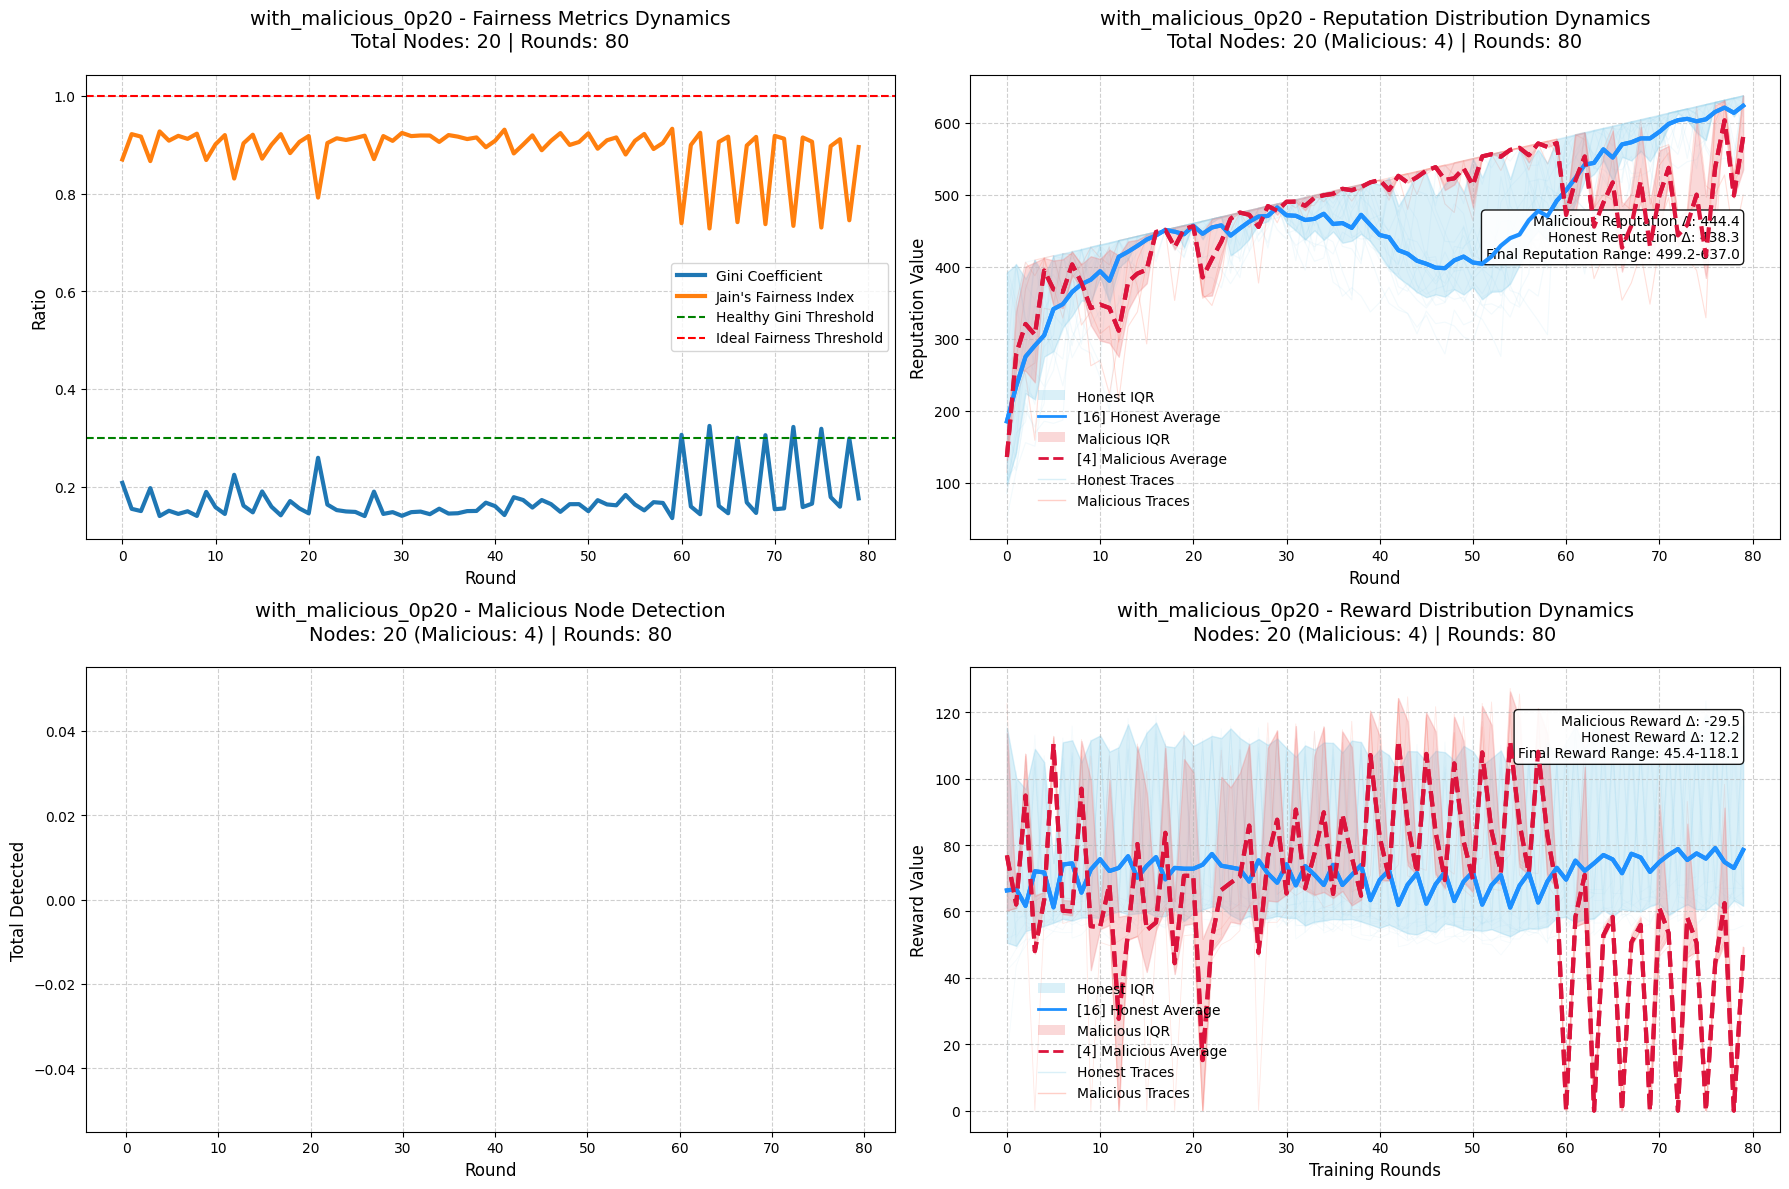

with_malicious_0p25
生成系统 'with_malicious_0p25' 的图表...


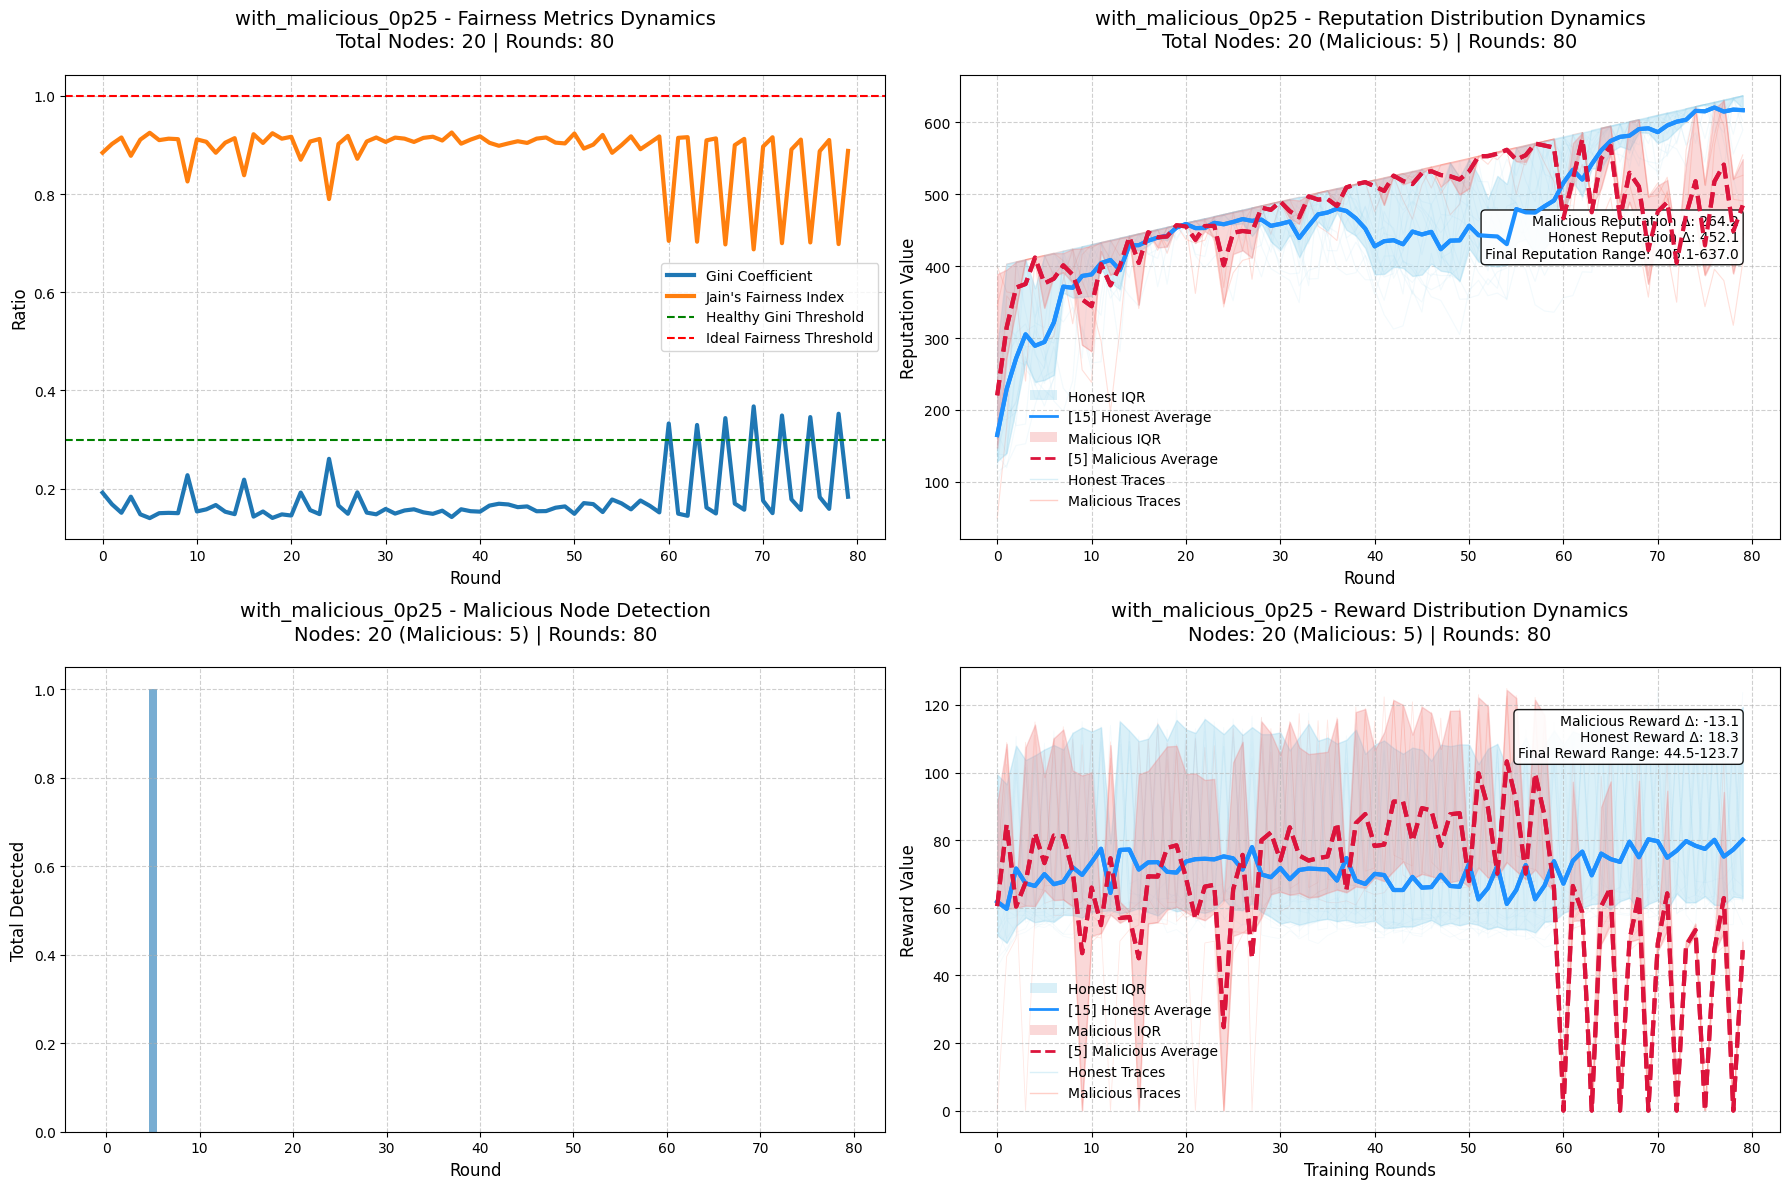

with_malicious_0p30
生成系统 'with_malicious_0p30' 的图表...


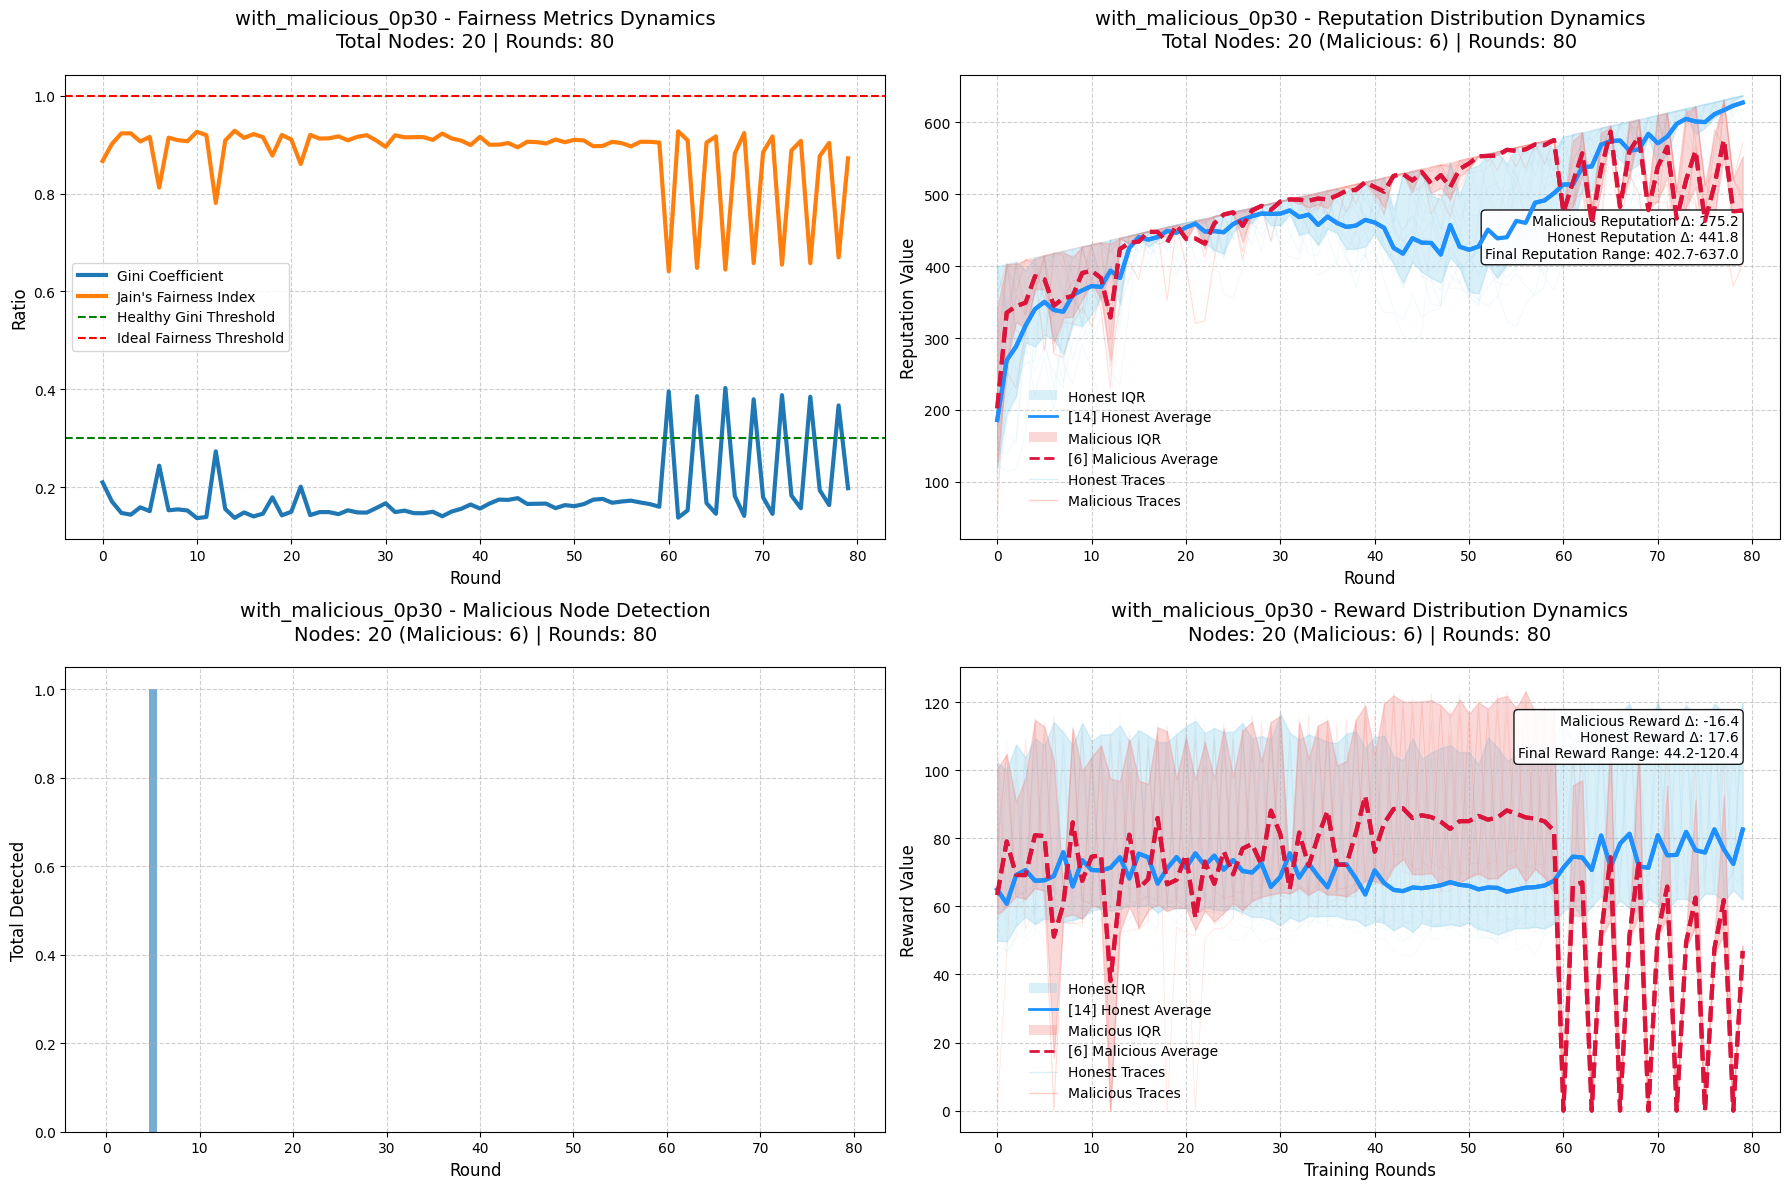

without_malicious
生成系统 'without_malicious' 的图表...


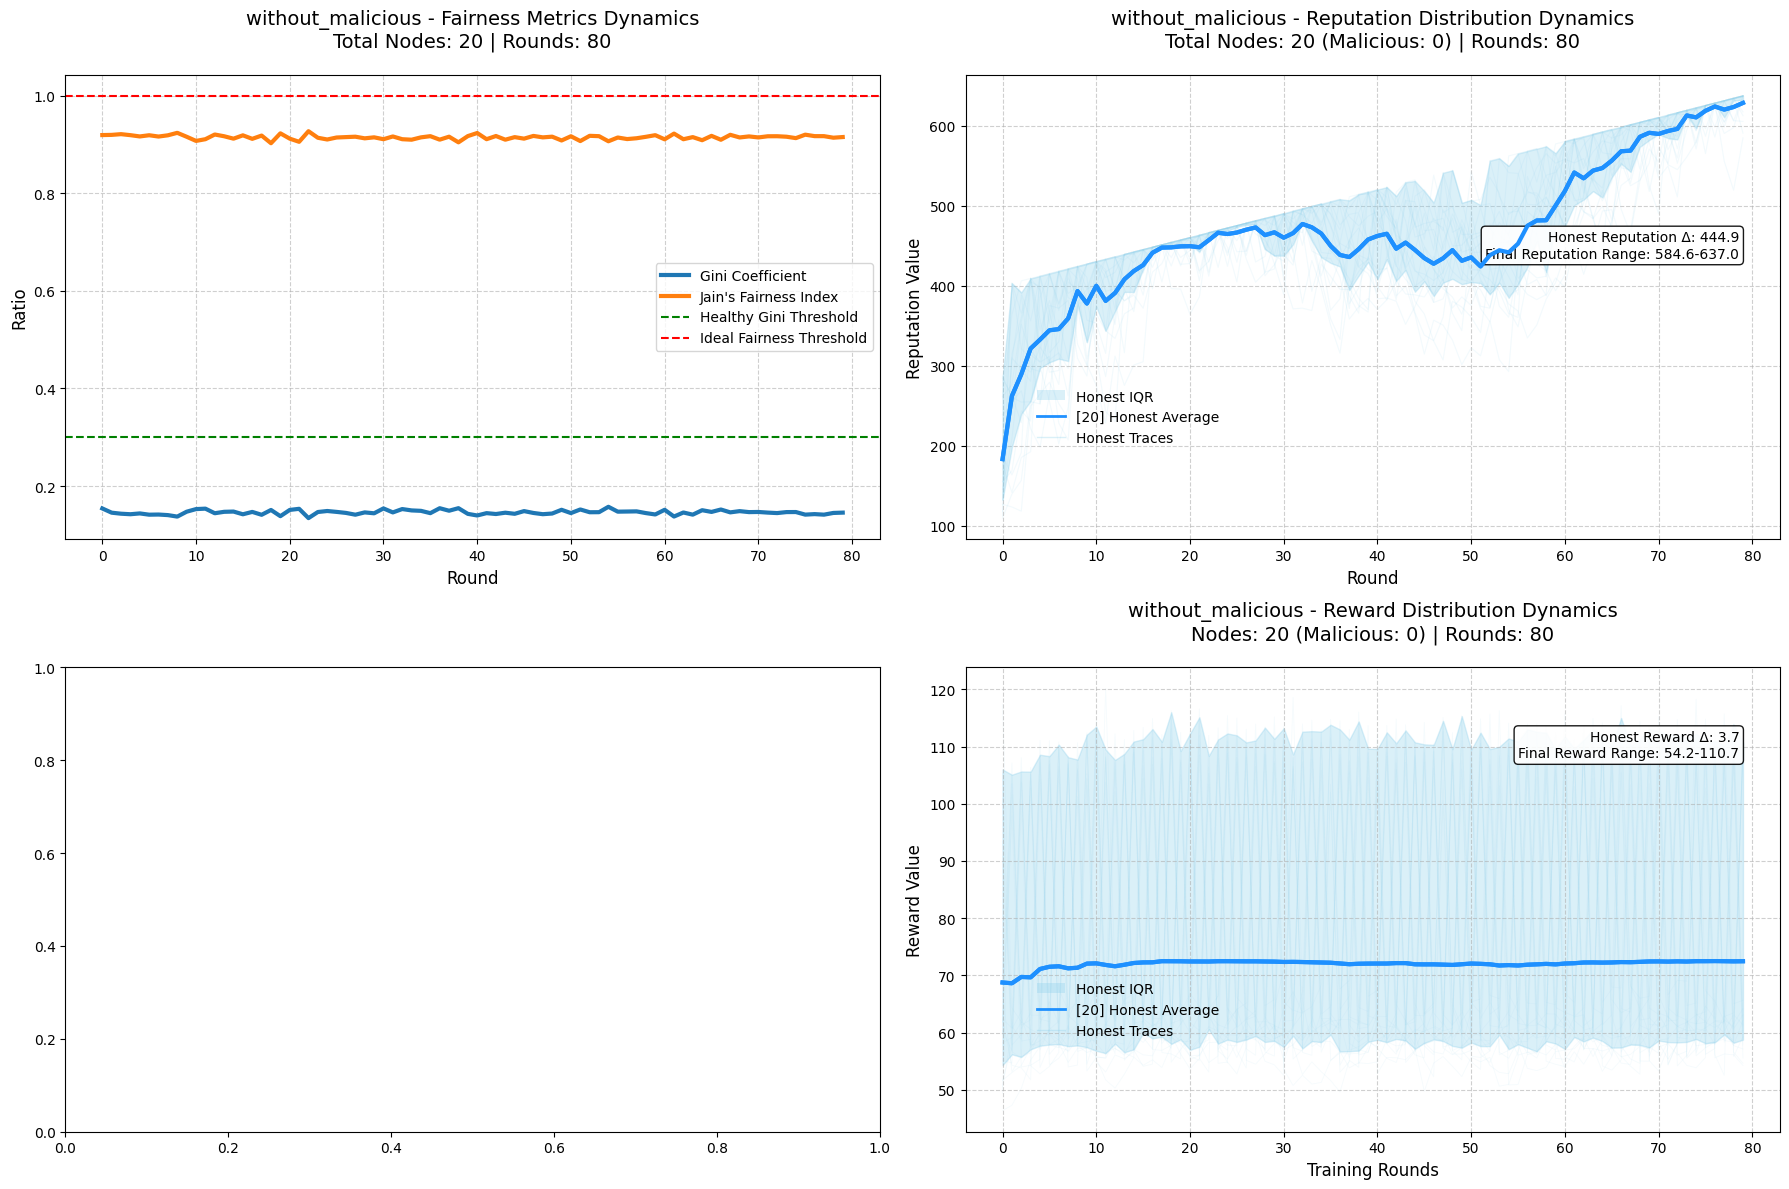


所有模拟和报告生成完毕。


In [10]:
# ================== Visualization Module ==================
def plot_metrics(system, label="System"):
    """System-Wide Metrics Visualization"""
    
    plt.figure(figsize=(18, 12))

    # ---------- Fairness metrics -------------
    plt.subplot(2, 2, 1)
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]

    plt.plot(system.gini_history, linewidth=3, label='Gini Coefficient')
    plt.plot(system.fairness_history, linewidth=3, label="Jain's Fairness Index")
    plt.axhline(0.3, color='green', linestyle='--', label='Healthy Gini Threshold')
    plt.axhline(1, color='red', linestyle='--', label='Ideal Fairness Threshold')
    plt.title(f'{label} - Fairness Metrics Dynamics\nTotal Nodes: {num_nodes} | Rounds: {len(rounds)}', 
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Ratio', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()
    plt.tight_layout()
    
    # --------- Reputation Distribution -----------
    plt.subplot(2, 2, 2)
    if not system.reputation_history:
        print("警告：无声誉数据可供可视化")
        plt.title('声誉数据未找到')
        return
    
    reps = np.array(system.reputation_history)
    rounds = np.arange(reps.shape[0])
    num_nodes = reps.shape[1]
    
    # Identify malicious nodes
    malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # Plot individual traces with group coloring
    for node_id in range(num_nodes):
        color = 'tomato' if node_id in malicious_ids else 'skyblue'
        alpha = 0.2 if node_id in malicious_ids else 0.1
        plt.plot(rounds, reps[:, node_id], 
                color=color, 
                alpha=alpha, 
                linewidth=0.8,
                zorder=1)
    
    # Calculate group averages
    if malicious_ids:
        malicious_avg = np.mean(reps[:, malicious_ids], axis=1)
        malicious_q1 = np.percentile(reps[:, malicious_ids], 25, axis=1)
        malicious_q3 = np.percentile(reps[:, malicious_ids], 95, axis=1)
    else:
        malicious_avg = np.array([])
        malicious_q1 = np.array([])
        malicious_q3 = np.array([])
    
    honest_avg = np.mean(reps[:, honest_ids], axis=1)
    honest_q1 = np.percentile(reps[:, honest_ids], 25, axis=1)
    honest_q3 = np.percentile(reps[:, honest_ids], 95, axis=1)
    
    # Plot group averages
    plt.plot(rounds, honest_avg, 
            color='dodgerblue', 
            linewidth=3, 
            linestyle='-',
            label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
            zorder=4)
    
    if len(malicious_avg) > 0:
        plt.plot(rounds, malicious_avg, 
                color='crimson', 
                linewidth=3, 
                linestyle='--',
                label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                zorder=5)

    # Plot overall mean comparison
    # total_avg = np.mean(reps, axis=1)
    # plt.plot(rounds, np.mean(reps, axis=1),
    #         color='gold', 
    #         linewidth=3,
    #         linestyle=':',
    #         label='Overall Mean',
    #         zorder=3)
    
    # Plot honest nodes statistics
    plt.fill_between(rounds, honest_q1, honest_q3,
                    color='skyblue', alpha=0.3,
                    label='Honest IQR', zorder=2)
    plt.plot(rounds, honest_avg,
            color='dodgerblue', lw=3,
            label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # Plot malicious nodes statistics (if any)
    if len(malicious_avg) > 0:
        plt.fill_between(rounds, malicious_q1, malicious_q3,
                        color='lightcoral', alpha=0.3,
                        label='Malicious IQR', zorder=2)
        plt.plot(rounds, malicious_avg,
                color='crimson', lw=3, linestyle='--',
                label=f'[{len(malicious_ids)}] Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # Formatting
    plt.title(f'{label} - Reputation Distribution Dynamics\n'
             f'Total Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}', 
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Reputation Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Create layered legend
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
        Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
    ]
    
    if len(malicious_avg) > 0:
        legend_elements.extend([
            Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
            Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
        ])
    
    legend_elements.extend([
        # Line2D([0], [0], color='gold', lw=2, ls=':', label='Overall Mean'),
        Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    ])
    
    if len(malicious_avg) > 0:
        legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    plt.legend(handles=legend_elements, 
              loc='upper center',
              bbox_to_anchor=(0.2, 0.35),  
              ncol=1,
              frameon=False,
              fontsize=10)
    
    # Add dynamic statistical annotations
    stats_text = []
    if len(malicious_avg) > 0:
        stats_text.append(f"Malicious Reputation Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    stats_text.extend([
        f"Honest Reputation Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
        f"Final Reputation Range: {np.min(reps[-1]):.1f}-{np.max(reps[-1]):.1f}",
        # f"Honest/Honest Ratio: {honest_avg[-1]/(total_avg[-1]+1e-8):.1f}x"
    ])
    
    plt.annotate('\n'.join(stats_text), 
                xy=(0.95, 0.6),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))

    
    # -------- Security Detection ------------
    plt.subplot(2, 2, 3)
    if malicious_ids:
        plt.bar(range(len(system.detection_history)), system.detection_history, alpha=0.6)
        plt.title(f'{label} - Malicious Node Detection\n'
                  f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
                  fontsize=14, pad=20)
        plt.xlabel('Round', fontsize=12)
        plt.ylabel('Total Detected', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
    
    # -------- Reward Distribution ------------
    plt.subplot(2, 2, 4)
    """Dynamic reward distribution visualization (including malicious/honest node distinction)"""
    if not system.reward_history:
        print("警告：无奖励数据可供可视化")
        return
    # Data preparation
    rewards = np.array(system.reward_history)
    rounds = np.arange(rewards.shape[0])
    num_nodes = rewards.shape[1]
    
    # Identify malicious nodes
    malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
    honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
    
    # Plot individual reward traces with group coloring
    for node_id in range(num_nodes):
        color = 'tomato' if node_id in malicious_ids else 'skyblue'
        alpha = 0.15 if node_id in malicious_ids else 0.08
        plt.plot(rounds, rewards[:, node_id], 
                color=color, 
                alpha=alpha, 
                linewidth=0.6,
                zorder=1)
    
    # Calculate group statistics
    if malicious_ids:
        malicious_avg = np.mean(rewards[:, malicious_ids], axis=1)
        malicious_q1 = np.percentile(rewards[:, malicious_ids], 25, axis=1)
        malicious_q3 = np.percentile(rewards[:, malicious_ids], 95, axis=1)
    else:
        malicious_avg = np.array([])
        malicious_q1 = np.array([])
        malicious_q3 = np.array([])
    
    honest_avg = np.mean(rewards[:, honest_ids], axis=1)
    honest_q1 = np.percentile(rewards[:, honest_ids], 25, axis=1)
    honest_q3 = np.percentile(rewards[:, honest_ids], 95, axis=1)
    
    # Plot group averages
    plt.plot(rounds, honest_avg, 
            color='dodgerblue', 
            linewidth=3, 
            linestyle='-',
            label=f'Honest Nodes Avg (μ={honest_avg[-1]:.1f})',
            zorder=4)
    
    if len(malicious_avg) > 0:
        plt.plot(rounds, malicious_avg, 
                color='crimson', 
                linewidth=3, 
                linestyle='--',
                label=f'Malicious Nodes Avg (μ={malicious_avg[-1]:.1f})',
                zorder=5)

    # Plot overall mean comparison
    # total_avg = np.mean(reps, axis=1)
    # plt.plot(rounds, np.mean(reps, axis=1),
    #         color='gold', 
    #         linewidth=3,
    #         linestyle=':',
    #         label='Overall Mean',
    #         zorder=3)
    
    # Plot honest nodes statistics
    plt.fill_between(rounds, honest_q1, honest_q3,
                    color='skyblue', alpha=0.3,
                    label='Honest IQR')
    plt.plot(rounds, honest_avg,
            color='dodgerblue', lw=3,
            label=f'[{len(honest_ids)}] Honest Avg (Final: {honest_avg[-1]:.1f})')
    
    # Plot malicious nodes statistics (if any)
    if len(malicious_avg) > 0:
        plt.fill_between(rounds, malicious_q1, malicious_q3,
                        color='lightcoral', alpha=0.3,
                        label='Malicious IQR')
        plt.plot(rounds, malicious_avg,
                color='crimson', lw=3, linestyle='--',
                label=f'[{len(malicious_ids)}] Malicious Avg (Final: {malicious_avg[-1]:.1f})')
    
    # Overall statistics reference lines
    plt.title(f'{label} - Reward Distribution Dynamics\n'
             f'Nodes: {num_nodes} (Malicious: {len(malicious_ids)}) | Rounds: {len(rounds)}',
             fontsize=14, pad=20)
    plt.xlabel('Training Rounds', fontsize=12)
    plt.ylabel('Reward Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Create layered legend
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
        Line2D([0], [0], color='dodgerblue', lw=2, label=f'[{len(honest_ids)}] Honest Average'),
    ]
    
    if len(malicious_avg) > 0:
        legend_elements.extend([
            Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
            Line2D([0], [0], color='crimson', lw=2, ls='--', label=f'[{len(malicious_ids)}] Malicious Average'),
        ])
    
    legend_elements.extend([
        # Line2D([0], [0], color='gold', lw=2, ls=':', label='Overall Mean'),
        Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'),
    ])
    
    if len(malicious_avg) > 0:
        legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
    
    plt.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.2, 0.35),
              ncol=1,
              frameon=False,
              fontsize=10)
    
    # Add dynamic statistical annotations
    stats_text = []
    if len(malicious_avg) > 0:
        stats_text.append(f"Malicious Reward Δ: {malicious_avg[-1]-malicious_avg[0]:.1f}")
    stats_text.extend([
        f"Honest Reward Δ: {honest_avg[-1]-honest_avg[0]:.1f}",
        f"Final Reward Range: {np.min(rewards[-1]):.1f}-{np.max(rewards[-1]):.1f}",
        # f"Honest/Honest Ratio: {honest_avg[-1]/(total_avg[-1]+1e-8):.1f}x"
    ])
    
    plt.annotate('\n'.join(stats_text), 
                xy=(0.95, 0.8),
                xycoords='axes fraction',
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', alpha=0.9, facecolor='white'))
    
    plt.tight_layout()
    plt.show()

# =================== Simulation Report =====================
def generate_simulation_report(system, filename):
    """
    Generates simulation reports for an FLSystem instance and saves them as CSV files.

    Parameters:
        system (FLSystem): The federated learning system instance containing simulation data.
        filename (str): The base filename for the generated reports. The function will create
                        two CSV files with suffixes '_round_metrics.csv' and '_node_summary.csv'.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
               (round_metrics_df, node_summary_df)
    """
    # Validate the filename extension
    if not filename.lower().endswith('.csv'):
        raise ValueError("Filename must end with '.csv'")
    
    # Derive base name without extension
    base, ext = os.path.splitext(filename)
    
    # Define filenames for round metrics and node summary
    round_metrics_filename = f"{base}_round_metrics.csv"
    node_summary_filename = f"{base}_node_summary.csv"
    
    # ------------------ Extract Per-Round Metrics ------------------
    rounds = list(range(1, system.current_round + 1))
    gini = system.gini_history
    fairness = system.fairness_history
    detected = system.detection_history
    penalties = system.penalty_history  # List of lists
    rewards = system.reward_history 
    committee_history = system.committee_history  # List of lists
    
    # Calculate total penalties per round
    total_penalties = [sum(penalty_round) for penalty_round in penalties]
    
    # Format committee members as comma-separated strings
    committee_members = [', '.join(map(str, committee)) for committee in committee_history]
    
    # Create a DataFrame for per-round metrics
    round_metrics_df = pd.DataFrame({
        'Round': rounds,
        'Gini Coefficient': gini,
        'Fairness Index': fairness,
        'Detected Malicious Nodes': detected,
        'Total Penalties': total_penalties,
        'Total Rewards': rewards,
        'Committee Members': committee_members
    })
    
    # ------------------ Extract Per-Node Summary Metrics ------------------
    node_ids = [node.id for node in system.nodes]
    stakes = [node.stake for node in system.nodes]
    final_reputations = [node.reputation for node in system.nodes]
    total_rewards = [node.total_reward for node in system.nodes]
    violations = [node.violations for node in system.nodes]
    participation = [node.participation for node in system.nodes]
    total_committee = [node.total_committee for node in system.nodes]
    cooldowns = [node.cooldown for node in system.nodes]
    
    # Create a DataFrame for per-node summary
    node_summary_df = pd.DataFrame({
        'Node ID': node_ids,
        'Stake': stakes,
        'Final Reputation': final_reputations,
        'Total Reward': total_rewards,
        'Violations': violations,
        'Participation Count': participation,
        'Total Committee Memberships': total_committee,
        'Current Cooldown': cooldowns
    })
    
    # ------------------ Save DataFrames to CSV Files ------------------
    try:
        # Save round metrics
        round_metrics_df.to_csv(round_metrics_filename, index=False)
        print(f"Round metrics saved to {round_metrics_filename}")
        
        # Save node summary
        node_summary_df.to_csv(node_summary_filename, index=False)
        print(f"Node summary metrics saved to {node_summary_filename}")
        
    except Exception as e:
        print(f"Error saving simulation reports: {e}")
        raise e
    
    # ------------------ Return DataFrames ------------------
    return round_metrics_df, node_summary_df

N =20
CS = 5
Base = 1200
rep_exponent = 0.5
stake_weight = 0.4
R = 80
# ================== Main Program ==================
if __name__ == "__main__":
    # Set fixed random seed for reproducibility
    np.random.seed(1411758002)
    import random
    random.seed(1411758002)
    

    
    # Initialize FL Systems with different malicious ratios
    systems = {
        "with_malicious_0p10": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent= rep_exponent,
            malicious_ratio=0.1,  # 10% malicious nodes
            phase_switch_round=30,
            # Sybil resistance not considered
        ),
        "with_malicious_0p15": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.15,  # 15% malicious nodes
            phase_switch_round=30,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p20": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.2,  # 20% malicious nodes
            phase_switch_round=30,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p25": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.25,  # 25% malicious nodes
            phase_switch_round=30,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        "with_malicious_0p30": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,  # Desired committee size
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.3,  # 30% malicious nodes
            phase_switch_round=30,
            # sybil_resistance=False  # Sybil resistance not considered
        ),
        "without_malicious": FLSystem(
            num_nodes=N,
            base_reward=Base,
            committee_size=CS,
            stake_weight=stake_weight,
            rep_exponent=rep_exponent,
            malicious_ratio=0.0,  # No malicious nodes
            phase_switch_round=30,
            # sybil_resistance=False
        )
    }
    
    # Define the number of rounds for simulations
    rounds_with_malicious = R
    rounds_without_malicious = R

    # Run Simulations for systems with malicious nodes
    print("开始运行包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_with_malicious), desc="包含恶意节点"):
        for key in ["with_malicious_0p10", "with_malicious_0p15", "with_malicious_0p20", "with_malicious_0p25", "with_malicious_0p30"]:
            systems[key].run_round()
    
    # Run Simulations for system without malicious nodes
    print("\n开始运行不包含恶意节点的模拟...")
    for _ in tqdm(range(rounds_without_malicious), desc="不包含恶意节点"):
        systems["without_malicious"].run_round()
    
    # Generate Reports
    print("\n生成模拟报告...")
    for key in systems:
        filename = f"simulation_report_{key}.csv"
        generate_simulation_report(systems[key], filename=filename)
    
    # Verify Committee Sizes
    def verify_committee_size(system, expected_size=CS):
        """
        Verify that each committee in the history meets the expected size.
        """
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    # Verify committee sizes for all systems
    print("\n验证所有系统的委员会规模...")
    for key in systems:
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # Generate Visualization for each system
    print("\n生成系统的可视化分析图表...")
    for key in systems:
        print(key)
        label = "With Malicious Nodes" if "with_malicious" in key else "Without Malicious Nodes"
        # if "with_malicious" in key:
        #     print(key.split('_')[-1][1:])
        #     # malicious_ratio_str = key.split('_')[-1][1:]
        #     # malicious_ratio = float(malicious_ratio_str) / 100
        #     # label += f" ({int(malicious_ratio * 100)}% Malicious)"
        # else:
        #     label += ""
        print(f"生成系统 '{key}' 的图表...")
        plot_metrics(systems[key], label=key)
    
    print("\n所有模拟和报告生成完毕。")


In [ ]:
system = FLSystem(num_nodes=50, malicious_ratio=0.2)
for _ in range(50):
    system.run_round()
print("Final average reputation:", np.mean(system.reputation_history[-1]))

In [ ]:
# 阶段化攻击测试
system = FLSystem(phase_switch_round=15)
for phase in [1, 2, 3]:
    for _ in range(20):
        system.run_round()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(system.fairness_history)
plt.title("Jain Fairness Index Over Rounds")
plt.xlabel("Round")
plt.ylabel("Fairness")
plt.show()

In [ ]:
# fl_simulation.py
"""
联邦学习激励机制仿真系统
包含：
1. 联邦学习节点和系统模拟器（修复了恶意节点检测逻辑）
2. 参数敏感度分析框架（增加异常处理）
3. 实验结果可视化（优化轨迹可视化显示）
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed
import plotly.express as px

# 全局配置
plt.rcParams.update({
    'font.family': 'SimHei',    # 中文显示
    'axes.unicode_minus': False # 解决负号显示问题
})
sns.set_style("whitegrid")

class Node:
    """联邦学习节点类"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake      # 质押量
        self.reputation = init_rep   # 声誉值
        self.total_reward = 0        # 累计奖励
        self.violations = 0          # 违规次数
        self.participation = 0       # 参与轮次
        self.consecutive = 0         # 连续参与轮次
        # 原有属性保持不变
        self.consecutive_committee = 0  # 新增：连续入选委员会轮次
        self.total_committee = 0        # 新增：总入选委员会次数

    def update_committee_status(self, is_in_committee):
        """更新委员会参与状态"""
        if is_in_committee:
            self.consecutive_committee += 1
            self.total_committee += 1
        else:
            self.consecutive_committee = 0  # 未入选时重置连续计数
      
    def act_normal(self):
        """正常行为: 贡献度7±2"""
        return max(0, np.random.normal(7, 2))
    
    def act_malicious(self, phase):
        """
        恶意行为模式
        phase 1: 刷贡献度(10±0.5)
        phase 2: 提交空模型(0)
        """
        if phase == 1:
            return max(9.5, np.random.normal(10, 0.2))
        else:
            return 0

class FLSystem:
    """联邦学习系统模拟器"""
    def __init__(self, 
                 num_nodes: int = 10,
                 base_reward: float = 1000,
                 committee_size: int = 10,
                 stake_weight: float = 0.5,
                 rep_exponent: float = 0.7,
                 init_stake: float = 100,
                 init_rep: float = 100,
                 malicious_threshold: float = 1,
                 phase_switch_round: int = 20,
                 malicious_ratio: float = 0.2):
        
        # 增强参数校验
        if not 0 <= malicious_ratio <= 1:
            raise ValueError("malicious_ratio必须在[0,1]范围内")
        if num_nodes <= 0 or not isinstance(num_nodes, int):
            raise ValueError("节点数量必须为正整数")
        if committee_size > num_nodes:
            raise ValueError("委员会规模不能超过节点总数")
        
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        self.base_reward = base_reward
        self.committee_size = min(committee_size, num_nodes)
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.malicious_threshold = malicious_threshold
        self.phase_switch_round = phase_switch_round
        self.malicious_ratio = malicious_ratio
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []

    def calculate_committee_reward(self, node):
        """计算委员会奖励（新公式）"""
        # 时间权重计算（带上限）
        time_weight = 1 + 0.1 * min(node.consecutive_committee, self.max_consecutive)
        
        # 均分奖励部分
        base_part = self.committee_pool / self.committee_size
        
        # 时间补贴部分
        subsidy_part = self.epoch_subsidy * time_weight
        
        return base_part + subsidy_part

    def dynamic_alpha(self, avg_rep):
        """动态质押权重系数"""
        return self.stake_weight * np.exp(-0.01 * avg_rep)
    
    def tanh_approx(self, x):
        """优化后的双曲正切近似"""
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1 + 1e-8)
    
    def update_reputation(self, node, contribution, penalty=0):
        """带衰减的声誉更新公式"""
        old_rep = node.reputation
        x = (old_rep - 100) / 50
        delta = 0.97 - 0.02 * self.tanh_approx(x)
        
        long_term = np.sqrt(node.participation + 1)
        noise = 0.2 * np.random.rand()
        
        new_rep = (old_rep * delta + 
                  contribution * (1 + noise) - 
                  penalty * old_rep * (0.1 + 0.05 * node.violations) +
                  long_term)
        
        return np.clip(new_rep, 0, 300)
    
    def calculate_reward(self, node, avg_rep, total_contribution):
        """多因素奖励计算"""
        alpha = self.dynamic_alpha(avg_rep)
        beta = 1 - alpha
        
        total_stake = sum(n.stake for n in self.nodes)
        stake_reward = alpha * self.base_reward * (node.stake / (total_stake + 1e-8))
        
        contrib_ratio = node.contribution / (total_contribution + 1e-8)
        rep_boost = np.log1p(node.reputation)
        contrib_reward = beta * self.base_reward * contrib_ratio * rep_boost
        
        committee_reward = 40 if node in self.committee else 0
        
        return stake_reward + contrib_reward + committee_reward
    
    def select_committee(self):
        """基于声誉的加权随机选择"""
        reps = np.array([n.reputation**self.rep_exponent for n in self.nodes])
        probs = reps / (reps.sum() + 1e-8)
        return np.random.choice(
            self.nodes, 
            size=self.committee_size,
            p=probs,
            replace=False
        )
    
    def run_round(self, malicious_nodes=None):
        """执行单轮训练"""
        contributions = []
        for node in self.nodes:
            if malicious_nodes and node in malicious_nodes:
                phase = 1 if self.current_round < self.phase_switch_round else 2
                contri = node.act_malicious(phase)
            else:
                contri = node.act_normal()
            contributions.append(contri)
        
        total_contribution = sum(contributions)
        avg_rep = np.mean([n.reputation for n in self.nodes])
        self.committee = self.select_committee()
        
        rewards = []
        for node, contri in zip(self.nodes, contributions):
            node.contribution = contri
            penalty = 0
            
            if contri < self.malicious_threshold:
                penalty = 0.1 + 0.05 * node.violations
                node.violations += 1
                
            node.reputation = self.update_reputation(node, contri, penalty)
            node.participation += 1
            
            reward = self.calculate_reward(node, avg_rep, total_contribution)
            node.total_reward += reward
            rewards.append(reward)
        
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.current_round += 1

# ================== 实验框架 ==================
def run_experiment(config: dict, num_rounds: int = 50, attack_type: str = 'collusion') -> dict:
    """执行单个实验"""
    allowed_params = [
        'num_nodes', 'base_reward', 'committee_size',
        'stake_weight', 'rep_exponent', 'init_stake',
        'init_rep', 'malicious_threshold', 'phase_switch_round',
        'malicious_ratio'
    ]
    
    system_params = {k: v for k, v in config.items() if k in allowed_params}
    system_params.setdefault('malicious_ratio', 0.0)
    
    try:
        fl = FLSystem(**system_params)
    except ValueError as e:
        print(f"系统初始化失败: {str(e)}")
        return {}

    num_malicious = max(0, min(
        int(system_params['num_nodes'] * system_params['malicious_ratio']),
        system_params['num_nodes']
    ))
    malicious_nodes = fl.nodes[:num_malicious] if attack_type != 'none' and num_malicious > 0 else None
    
    for _ in range(num_rounds):
        fl.run_round(malicious_nodes)
    
    return {
        'reputation_history': np.array(fl.reputation_history),
        'reward_history': np.array(fl.reward_history),
        'final_reps': [n.reputation for n in fl.nodes],
        'final_rewards': fl.reward_history[-1] if fl.reward_history else [],
        'final_violations': [n.violations for n in fl.nodes],
        'config': system_params,
        'num_malicious': num_malicious
    }

def gini(x):
    """基尼系数计算（修正版）"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def jain_fairness(x):
    """Jain公平性指数"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x) ** 2) / (len(x) * np.sum(x ** 2) + 1e-8)

def parameter_sweep(param_grid, num_rounds=50, n_jobs=-1):
    """参数扫描主函数（增加进度条）"""
    configs = [dict(zip(param_grid.keys(), v)) 
              for v in product(*param_grid.values())]
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_experiment)(config, num_rounds) for config in tqdm(configs, desc="参数扫描进度")
    )
    
    processed = []
    for res in results:
        if not res:
            continue
            
        cfg = res['config']
        reps = res['final_reps']
        rewards = res['final_rewards']
        num_malicious = res['num_malicious']
        
        metrics = {
            'gini_final': gini(rewards),
            'jain_fairness': jain_fairness(rewards),  # 新增指标
            'avg_reward': np.mean(rewards) if len(rewards) > 0 else 0,
            'honest_rep': np.mean(reps[num_malicious:]) if num_malicious > 0 else np.mean(reps),
            'attack_impact': np.mean(reps[:num_malicious])/np.mean(reps[num_malicious:]) if num_malicious > 0 else 0
        }
        
        processed.append({**cfg, **metrics})
    
    return pd.DataFrame(processed)


# ================== 可视化函数 ==================
def plot_reputation_fairness_analysis(results_df):
    """声誉指数对公平性指标的影响分析"""
    plt.figure(figsize=(18, 8), dpi=120)
    plt.suptitle("Reputation Exponent vs. Fairness Metrics", 
                fontsize=16, y=1.05, fontweight='bold')
    
    # ================== 散点图矩阵分析 ==================
    ax1 = plt.subplot(131)
    sns.scatterplot(
        data=results_df,
        x='rep_exponent',
        y='gini_final',
        hue='jain_fairness',
        size='committee_size',
        palette="viridis",
        sizes=(30, 200),
        alpha=0.8,
        edgecolor='k',
        linewidth=0.5
    )
    sns.regplot(
        data=results_df,
        x='rep_exponent',
        y='gini_final',
        scatter=False,
        color='red',
        line_kws={'linestyle': '--', 'alpha': 0.7}
    )
    ax1.set_title("A. Reputation Exponent vs. Gini Index\n(趋势线展示负相关性)", fontsize=12)
    ax1.set_xlabel("Reputation Exponent", fontsize=10)
    ax1.set_ylabel("Gini Index", fontsize=10)
    
    # ================== 分位数箱线图分析 ==================
    ax2 = plt.subplot(132)
    results_df['rep_exponent_bin'] = pd.qcut(
        results_df['rep_exponent'],
        q=4,
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    sns.boxplot(
        data=results_df,
        x='rep_exponent_bin',
        y='jain_fairness',
        order=['Low', 'Medium', 'High', 'Very High'],
        palette="Blues",
        showmeans=True,
        meanprops={"marker":"D", "markerfacecolor":"white", "markeredgecolor":"black"}
    )
    ax2.axhline(0.9, color='green', linestyle='--', alpha=0.5, label='Good Fairness')
    ax2.set_title("B. Jain's Fairness Distribution\n(分位数分组对比)", fontsize=12)
    ax2.set_xlabel("Reputation Exponent Quantile", fontsize=10)
    ax2.set_ylabel("Jain's Fairness Index", fontsize=10)
    ax2.legend(loc='lower right')
    
    # ================== 3D曲面图分析 ==================
    from mpl_toolkits.mplot3d import Axes3D
    ax3 = plt.subplot(133, projection='3d')
    
    # 数据准备
    pivot_df = results_df.pivot_table(
        index='rep_exponent',
        columns='stake_weight',
        values=['gini_final', 'jain_fairness'],
        aggfunc='median'
    )
    
    # 绘制曲面
    X, Y = np.meshgrid(pivot_df.index, pivot_df.columns.levels[1])
    Z_gini = pivot_df['gini_final'].values.T
    Z_jain = pivot_df['jain_fairness'].values.T
    
    ax3.plot_surface(X, Y, Z_gini, cmap='coolwarm', alpha=0.8, label='Gini')
    ax3.plot_surface(X, Y, Z_jain, cmap='viridis', alpha=0.5, label='Jain')
    
    ax3.set_title("C. 3D Parameter Space Analysis", fontsize=12)
    ax3.set_xlabel("Reputation Exponent", fontsize=9)
    ax3.set_ylabel("Stake Weight", fontsize=9)
    ax3.set_zlabel("Metric Value", fontsize=9)
    ax3.view_init(25, 45)
    
    plt.tight_layout()
    plt.savefig('reputation_fairness_analysis.png', bbox_inches='tight', dpi=300)
    plt.show()

def plot_node_distributions(experiment_result, figsize=(20, 6)):
    """Enhanced Visualization of Node Metrics Distribution"""
    if not experiment_result:
        return
    
    plt.figure(figsize=figsize, dpi=120)
    
    # Data preparation
    rewards = np.array(experiment_result.get('final_rewards', []))
    reputations = np.array(experiment_result.get('final_reps', []))
    violations = np.array(experiment_result.get('final_violations', []))
    
    # Reward Distribution
    plt.subplot(1, 3, 1)
    ax1 = sns.histplot(rewards, kde=True, bins=20, color='#1f77b4', edgecolor='w')
    stats_text = f"Mean: {np.mean(rewards):.1f}\nMedian: {np.median(rewards):.1f}\nStd: {np.std(rewards):.1f}"
    ax1.text(0.95, 0.85, stats_text, transform=ax1.transAxes, ha='right', 
            va='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.title('Reward Distribution', fontsize=12)
    
    # Violation Distribution
    plt.subplot(1, 3, 2)
    unique, counts = np.unique(violations, return_counts=True)
    colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(unique)))
    bars = plt.bar(unique, counts, color=colors, edgecolor='black')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, 
                f'{height}\n({height/len(violations):.1%})', 
                ha='center', va='bottom', fontsize=8)
    
    plt.title(f'Violation Count Distribution (Total: {sum(violations)})', fontsize=12)
    plt.xlabel('Violation Count')
    plt.ylabel('Number of Nodes')

    # 动态图例配置
    legend_elements = [plt.Rectangle((0,0),1,1, 
                                   facecolor=colors[i],
                                   edgecolor='black',
                                   label=f'Violations: {v}') 
                      for i, v in enumerate(unique)]
    
    # 智能布局判断
    if len(unique) <= 4:
        legend_loc = {'loc': 'upper right', 'bbox_to_anchor': (0.95, 0.95)}
    else:
        legend_loc = {'loc': 'lower center', 
                     'ncol': min(4, len(unique)//2),
                     'bbox_to_anchor': (0.5, -0.25)}
    
    plt.legend(handles=legend_elements,
              title="Violation Levels",
              **legend_loc,

              frameon=True,
              title_fontsize=10,
              fontsize=9,
              facecolor='whitesmoke')
    
    # --------- Reputation Distribution -----------
    plt.subplot(1, 3, 3)
    ax3 = sns.violinplot(y=reputations, color='#2ca02c', inner="quartile")
    # percentiles = [np.percentile(reputations, q) for q in [25, 50, 75]]
    # for p in percentiles:
    #     plt.axhline(p, color='red', linestyle='--', alpha=0.7)
    # plt.title(f'Reputation Distribution (Median: {np.median(reputations):.1f})', fontsize=12)

    # 关键分界线
    # percentiles = [10, 25, 50, 75, 90]
    percentiles = [25, 50, 75, 90]
    for q in percentiles:
        plt.axhline(np.percentile(reputations, q), 
                   color='red' if q == 50 else 'purple',
                   linestyle='--' if q == 50 else ':',
                   linewidth=1.2,
                   alpha=0.7)
    
    # 动态标注
    stats_text = "\n".join([f'P{q}: {np.percentile(reputations, q):.1f}' 
                          for q in percentiles])
    plt.text(0.05, 0.95, stats_text,
            transform=ax3.transAxes,
            fontsize=9,
            color='darkred',
            va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Reputation Distribution (Median: {:.1f})'.format(np.median(reputations)), 
             fontsize=12, pad=15)
    plt.ylabel('Reputation Value', fontsize=10)
    plt.xlabel('')
    plt.grid(True, linestyle='--', alpha=0.5)

    # 全局布局调整
    plt.tight_layout(pad=3)
    plt.subplots_adjust(right=0.85)  # 为右侧图例留出空间
    plt.show()

def plot_individual_trajectories(experiment_result, num_samples=5):
    """Visualization of Individual Metrics Trajectories (Optimized Display)"""
    if not experiment_result:
        return
    
    # Data preparation
    config = experiment_result.get('config', {})
    num_nodes = config.get('num_nodes', 0)
    num_malicious = experiment_result.get('num_malicious', 0)
    reps_history = experiment_result.get('reputation_history', np.array([]))
    rewards_history = experiment_result.get('reward_history', np.array([]))
    
    if reps_history.size == 0 or rewards_history.size == 0:
        print("Missing historical data")
        return
    
    num_honest = num_nodes - num_malicious
    
    plt.figure(figsize=(16, 6), dpi=120)
    rounds = np.arange(reps_history.shape[0])

    # ===== Reputation Dynamics =====
    plt.subplot(1, 2, 1)
    # Malicious Node Trajectories
    if num_malicious > 0:
        sample_malicious = np.random.choice(range(num_malicious), min(num_samples, num_malicious), replace=False)
        for idx in sample_malicious:
            plt.plot(rounds, reps_history[:, idx], color='red', alpha=0.3)
        plt.plot(rounds, reps_history[:, :num_malicious].mean(axis=1), 
                '--', color='darkred', linewidth=2, label=f'[{num_malicious}] Malicious Nodes Average')

    # Honest Node Trajectories
    if num_honest > 0:
        sample_honest = np.random.choice(range(num_malicious, num_nodes), min(num_samples, num_honest), replace=False)
        for idx in sample_honest:
            plt.plot(rounds, reps_history[:, idx], color='green', alpha=0.3)
        plt.plot(rounds, reps_history[:, num_malicious:].mean(axis=1), 
                '--', color='darkgreen', linewidth=2, label=f'[{num_honest}] Honest Nodes Average ')

    plt.title('Reputation Dynamics', fontsize=12)
    plt.xlabel('Training Rounds', fontsize=10)
    plt.ylabel('Reputation Value', fontsize=10)
    # Configure legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(unique_labels.values(), unique_labels.keys(),
            loc='upper center', bbox_to_anchor=(0.5, -0.15),
            ncol=2, frameon=False)

    # ===== Reward Dynamics =====
    plt.subplot(1, 2, 2)
    # Malicious Node Trajectories
    if num_malicious > 0:
        for idx in sample_malicious:
            plt.plot(rounds, rewards_history[:, idx], color='red', alpha=0.3)
        plt.plot(rounds, rewards_history[:, :num_malicious].mean(axis=1), 
                '--', color='darkred', linewidth=2, label=f'[{num_malicious}] Malicious Nodes Average')

    # Honest Node Trajectories
    if num_honest > 0:
        for idx in sample_honest:
            plt.plot(rounds, rewards_history[:, idx], color='green', alpha=0.3)
        plt.plot(rounds, rewards_history[:, num_malicious:].mean(axis=1), 
                '--', color='darkgreen', linewidth=2, label=f'[{num_honest}] Honest Nodes Average')

    plt.title('Reward Dynamics', fontsize=12)
    plt.xlabel('Training Rounds', fontsize=10)
    plt.ylabel('Reward Value', fontsize=10)
    # Configure legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(unique_labels.values(), unique_labels.keys(),
            loc='upper center', bbox_to_anchor=(0.5, -0.15),
            ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# ================== 主程序 ==================
if __name__ == "__main__":
    
    # 示例配置
    demo_config = {
        'num_nodes': 100,
        'base_reward': 1000,
        'committee_size': 1,
        'stake_weight': 0.5,
        'rep_exponent': 0.7,
        'malicious_ratio': 0.1,
        'phase_switch_round': 15
    }
    
    # 运行示例实验
    print("运行示例实验...")
    demo_result = run_experiment(demo_config, num_rounds=80)
    
    # 可视化结果
    if demo_result:
        print("\n生成节点分布图...")
        plot_node_distributions(demo_result)
        
        print("\n生成个体轨迹图...")
        plot_individual_trajectories(demo_result, num_samples=3)

        print(gini(demo_result['final_rewards']))
        print(gini(demo_result['final_reps']))
    else:
        print("示例实验运行失败")

In [ ]:
if __name__ == "__main__":
    # 参数配置（扩展声誉指数范围）
    param_grid = {
        'rep_exponent': np.linspace(0.3, 1.2, 10),  # 扩展参数范围
        'stake_weight': [0.3, 0.5, 0.7],
        'committee_size': [5, 10],
        'num_nodes': [100],
        'base_reward': [1000],
        'malicious_ratio': [0.2]
    }
    
    # 运行参数扫描
    print("执行参数扫描...")
    results_df = parameter_sweep(param_grid, num_rounds=50, n_jobs=4)
    
    # 过滤数据（固定其他参数）
    analysis_df = results_df[
        (results_df['num_nodes'] == 100) &
        (results_df['base_reward'] == 1000) &
        (results_df['malicious_ratio'] == 0.2)
    ]
    
    # 生成分析图表
    print("\n生成公平性分析图表...")
    plot_reputation_fairness_analysis(analysis_df)


In [ ]:
# ================== 主程序 ==================
if __name__ == "__main__":
    # 参数扫描配置
    param_grid = {
        'num_nodes': [100],
        'base_reward': [1000],
        'committee_size': [5, 10, 15],
        'stake_weight': [0.3, 0.5, 0.7],
        'rep_exponent': [0.5, 0.7, 0.9],
        'malicious_ratio': [0.2]
    }
    
    # 执行参数扫描
    print("正在执行参数扫描...")
    # results_df = parameter_sweep(param_grid, num_rounds=50)
    
    # 生成可视化图表
    print("\n生成热力图矩阵...")
    # plot_metric_heatmaps(results_df)
    
    print("生成3D优化曲面图...")
    # plot_3d_optimization(results_df)
    
    print("生成交互式平行坐标图...")
    plot_parallel_coords(analysis_df)

In [ ]:
"""
Federated Learning Incentive Simulation System v2.0
Includes full parameter sweep and visualization analysis features
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# ================== Global Configuration ==================
plt.rcParams.update({
    'font.family': 'Arial',      # Default font
    'axes.unicode_minus': False  # Fix negative sign display issue
})
sns.set_style("whitegrid")

class Node:
    """Federated Learning Node Class"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake      # Stake amount
        self.reputation = init_rep   # Reputation value
        self.total_reward = 0        # Accumulated rewards
        self.violations = 0          # Number of violations
        self.participation = 0       # Number of participation rounds
        self.consecutive = 0         # Consecutive participation rounds

    def act_normal(self):
        """Normal behavior: contribution of 7±2"""
        return max(0, np.random.normal(7, 2))
    
    def act_malicious(self, phase):
        """
        Malicious behavior patterns
        phase 1: Boost contribution (10±0.5)
        phase 2: Submit empty model (0)
        """
        if phase == 1:
            return max(9.5, np.random.normal(10, 0.2))
        else:
            return 0


class FLSystem:
    """Federated Learning System Simulator (Enhanced Version)"""
    def __init__(self, 
                 num_nodes: int = 100,
                 base_reward: float = 1000,
                 committee_size: int = 10,
                 stake_weight: float = 0.5,
                 rep_exponent: float = 0.7,
                 init_stake: float = 100,
                 init_rep: float = 100,
                 malicious_threshold: float = 1,
                 phase_switch_round: int = 20,
                 malicious_ratio: float = 0.2):
        
        # Parameter Validation
        if not 0 <= malicious_ratio <= 1:
            raise ValueError("malicious_ratio must be in [0, 1]")
        if num_nodes <= 0 or not isinstance(num_nodes, int):
            raise ValueError("Number of nodes must be a positive integer")
        if committee_size > num_nodes:
            raise ValueError("Committee size cannot exceed the total number of nodes")
        if not 0 <= stake_weight <= 1:
            raise ValueError("stake_weight must be in [0, 1]")
        if rep_exponent <= 0:
            raise ValueError("rep_exponent must be positive")
        
        self.nodes = [Node(i + 1, init_stake, init_rep) for i in range(num_nodes)]
        self.base_reward = base_reward
        self.committee_size = min(committee_size, num_nodes)
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.malicious_threshold = malicious_threshold
        self.phase_switch_round = phase_switch_round
        self.malicious_ratio = malicious_ratio
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []

    def dynamic_alpha(self, avg_rep):
        """Dynamic Stake Weight Coefficient"""
        return self.stake_weight * np.exp(-0.01 * avg_rep)
    
    def tanh_approx(self, x):
        """Optimized Hyperbolic Tangent Approximation"""
        return (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1 + 1e-8)
    
    def update_reputation(self, node, contribution, penalty=0):
        """Reputation Update with Decay"""
        old_rep = node.reputation
        x = (old_rep - 100) / 50
        delta = 0.97 - 0.02 * self.tanh_approx(x)
        
        long_term = np.sqrt(node.participation + 1)
        noise = 0.2 * np.random.rand()
        
        new_rep = (old_rep * delta + 
                  contribution * (1 + noise) - 
                  penalty * old_rep * (0.1 + 0.05 * node.violations) +
                  long_term)
        
        return np.clip(new_rep, 0, 300)
    
    def calculate_reward(self, node, avg_rep, total_contribution):
        """Multi-factor Reward Calculation"""
        alpha = self.dynamic_alpha(avg_rep)
        beta = 1 - alpha
        
        total_stake = sum(n.stake for n in self.nodes)
        stake_reward = alpha * self.base_reward * (node.stake / (total_stake + 1e-8))
        
        contrib_ratio = node.contribution / (total_contribution + 1e-8)
        rep_boost = np.log1p(node.reputation)
        contrib_reward = beta * self.base_reward * contrib_ratio * rep_boost
        
        committee_reward = 40 if node in self.committee else 0
        
        return stake_reward + contrib_reward + committee_reward
    
    def select_committee(self):
        """Reputation-based Weighted Random Selection"""
        reps = np.array([n.reputation**self.rep_exponent for n in self.nodes])
        probs = reps / (reps.sum() + 1e-8)
        return np.random.choice(
            self.nodes, 
            size=self.committee_size,
            p=probs,
            replace=False
        )
    
    def run_round(self, malicious_nodes=None):
        """Run a Single Training Round"""
        contributions = []
        for node in self.nodes:
            if malicious_nodes and node in malicious_nodes:
                phase = 1 if self.current_round < self.phase_switch_round else 2
                contri = node.act_malicious(phase)
            else:
                contri = node.act_normal()
            contributions.append(contri)
        
        total_contribution = sum(contributions)
        avg_rep = np.mean([n.reputation for n in self.nodes])
        self.committee = self.select_committee()
        
        rewards = []
        for node, contri in zip(self.nodes, contributions):
            node.contribution = contri
            penalty = 0
            
            if contri < self.malicious_threshold:
                penalty = 0.1 + 0.05 * node.violations
                node.violations += 1
                
            node.reputation = self.update_reputation(node, contri, penalty)
            node.participation += 1
            
            reward = self.calculate_reward(node, avg_rep, total_contribution)
            node.total_reward += reward
            rewards.append(reward)
        
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.current_round += 1

# ================== Experiment Framework ==================

# Remaining code is similar with comments and texts translated for consistency

# ================== 实验框架 ==================
def run_experiment(config: dict, num_rounds: int = 50) -> dict:
    """执行单个实验"""
    allowed_params = [
        'num_nodes', 'base_reward', 'committee_size',
        'stake_weight', 'rep_exponent', 'init_stake',
        'init_rep', 'malicious_threshold', 'phase_switch_round',
        'malicious_ratio'
    ]
    
    system_params = {k: v for k, v in config.items() if k in allowed_params}
    system_params.setdefault('malicious_ratio', 0.0)
    
    try:
        fl = FLSystem(**system_params)
    except ValueError as e:
        print(f"系统初始化失败: {str(e)}")
        return {}

    num_malicious = max(0, min(
        int(system_params['num_nodes'] * system_params['malicious_ratio']),
        system_params['num_nodes']
    ))
    # 安全索引处理
    malicious_nodes = fl.nodes[:num_malicious] if num_malicious < len(fl.nodes) else []
    
    for _ in range(num_rounds):
        fl.run_round(malicious_nodes)
    
    return {
        'reputation_history': np.array(fl.reputation_history),
        'reward_history': np.array(fl.reward_history),
        'final_reps': [n.reputation for n in fl.nodes],
        'final_rewards': fl.reward_history[-1] if fl.reward_history else [],
        'final_violations': [n.violations for n in fl.nodes],
        'config': system_params,
        'num_malicious': num_malicious
    }

def gini(x):
    """基尼系数计算（修正版）"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def jain_fairness(x):
    """Jain公平性指数"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x) ** 2) / (len(x) * np.sum(x ** 2) + 1e-8)

def parameter_sweep(param_grid, num_rounds=50, n_jobs=-1):
    """参数扫描主函数（增强版）"""
    configs = [dict(zip(param_grid.keys(), v)) 
              for v in product(*param_grid.values())]
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_experiment)(config, num_rounds) for config in tqdm(configs, desc="参数扫描进度")
    )
    
    processed = []
    for res in results:
        if not res:
            continue
            
        cfg = res['config']
        reps = res['final_reps']
        rewards = res['final_rewards']
        num_malicious = res['num_malicious']
        
        metrics = {
            'gini_final': gini(rewards),
            'jain_fairness': jain_fairness(rewards),
            'avg_reward': np.mean(rewards) if len(rewards) > 0 else 0,
            'honest_rep': np.mean(reps[num_malicious:]) if num_malicious > 0 else np.mean(reps),
            'attack_impact': (np.mean(reps[:num_malicious])/np.mean(reps[num_malicious:]) 
                             if num_malicious > 0 and np.mean(reps[num_malicious:]) > 0 else 0)
        }
        
        processed.append({**cfg, **metrics})
    
    return pd.DataFrame(processed)

# ================== 可视化模块 ==================
def plot_metric_heatmaps(results_df):
    """参数耦合热力图矩阵"""
    plt.figure(figsize=(18, 6), dpi=120)
    plt.suptitle("参数耦合效应对核心指标的影响", fontsize=16, y=1.05)
    
    metrics = [
        ('gini_final', '基尼系数', 'coolwarm'),
        ('jain_fairness', 'Jain公平性', 'viridis'),
        ('attack_impact', '攻击影响比', 'RdYlBu_r')
    ]
    
    for idx, (metric, title, cmap) in enumerate(metrics, 1):
        ax = plt.subplot(1, 3, idx)
        pivot = results_df.pivot_table(
            index='stake_weight', 
            columns='rep_exponent', 
            values=metric, 
            aggfunc='median'
        ).fillna(0)
        
        sns.heatmap(
            pivot, 
            annot=True, 
            fmt=".2f", 
            cmap=cmap,
            cbar_kws={'label': title},
            ax=ax
        )
        ax.set_title(f"{title}热力图", fontsize=12)
        ax.set_xlabel("声誉指数", fontsize=10)
        ax.set_ylabel("质押权重", fontsize=10)
    
    plt.tight_layout()
    plt.savefig('heatmaps.png', bbox_inches='tight')
    plt.show()

def plot_3d_optimization(results_df):
    """三维参数空间优化分析"""
    fig = plt.figure(figsize=(12, 8), dpi=120)
    ax = fig.add_subplot(111, projection='3d')
    
    # 数据准备
    valid_data = results_df.dropna(subset=['gini_final', 'jain_fairness'])
    x = valid_data['rep_exponent']
    y = valid_data['stake_weight']
    z_gini = valid_data['gini_final']
    z_jain = valid_data['jain_fairness']
    
    # 绘制曲面
    ax.plot_trisurf(x, y, z_gini, cmap='coolwarm', alpha=0.7, label='基尼系数')
    ax.plot_trisurf(x, y, z_jain, cmap='viridis', alpha=0.4, label='公平性')
    
    # 标注最优点
    min_gini = valid_data.loc[valid_data['gini_final'].idxmin()]
    ax.scatter(min_gini['rep_exponent'], min_gini['stake_weight'], min_gini['gini_final'],
              color='red', s=100, label='最优基尼')
    
    max_jain = valid_data.loc[valid_data['jain_fairness'].idxmax()]
    ax.scatter(max_jain['rep_exponent'], max_jain['stake_weight'], max_jain['jain_fairness'],
              color='green', s=100, marker='^', label='最优公平')
    
    ax.set_title("三维参数空间优化分析", fontsize=14)
    ax.set_xlabel("声誉指数", fontsize=10)
    ax.set_ylabel("质押权重", fontsize=10)
    ax.set_zlabel("指标值", fontsize=10)
    ax.view_init(25, 45)
    ax.legend()
    
    plt.savefig('3d_optimization.png', bbox_inches='tight')
    plt.show()

def plot_parallel_coords(results_df):
    """交互式平行坐标图"""
    fig = px.parallel_coordinates(
        results_df,
        dimensions=['stake_weight', 'rep_exponent', 'committee_size', 
                   'gini_final', 'jain_fairness', 'attack_impact'],
        color='gini_final',
        color_continuous_scale=px.colors.diverging.RdYlBu_r,
        labels={
            'stake_weight': 'stake_weight',
            'rep_exponent': 'rep_exponent',
            'committee_size': 'committee_size',
            'gini_final': 'gini_final',
            'jain_fairness': 'jain_fairness',
            'attack_impact': 'attack_impact'
        },
        title="参数组合平行坐标分析"
    )
    fig.write_html("parallel_coords.html")
    fig.show()

# ================== 主程序 ==================
if __name__ == "__main__":
    # 参数扫描配置
    param_grid = {
        'num_nodes': [10, 50, 100],
        'base_reward': [300, 800, 1000],
        'committee_size': [3, 5, 10],
        'stake_weight': [0.3, 0.5, 0.7],
        'rep_exponent': [0.5, 0.7, 0.9],
        'malicious_ratio': [0.2,0.5, 0.7],
        'phase_switch_round': [15, 20, 25]
    }
    
    # 执行参数扫描
    print("正在执行参数扫描...")
    results_df = parameter_sweep(param_grid, num_rounds=50, n_jobs=4)
    
    # 生成可视化图表
    print("\n生成热力图矩阵...")
    plot_metric_heatmaps(results_df)
    
    print("生成三维优化曲面图...")
    plot_3d_optimization(results_df)
    
    print("生成交互式平行坐标图...")
    plot_parallel_coords(results_df)

In [ ]:
# fl_simulation.py
"""
联邦学习激励机制仿真系统（改进版）
包含：
1. 带动态惩罚和随机保障的委员会机制
2. 参数敏感度分析框架
3. 增强的可视化功能
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed
import plotly.express as px

# 全局配置
plt.rcParams.update({
    'font.family': 'SimHei',    # 中文显示
    'axes.unicode_minus': False 
})
sns.set_style("whitegrid")

class Node:
    """联邦学习节点类（新增委员会参与跟踪）"""
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.consecutive_committee = 0  # 连续入选委员会轮次
        self.total_committee = 0        # 总入选次数
        
    def update_committee_status(self, is_in_committee):
        """更新委员会参与状态"""
        if is_in_committee:
            self.consecutive_committee += 1
            self.total_committee += 1
        else:
            self.consecutive_committee = 0
            
    def act_normal(self):
        """正常行为: 贡献度7±2"""
        return max(0, np.random.normal(7, 2))
    
    def act_malicious(self, phase):
        """
        恶意行为模式
        phase 1: 刷贡献度(10±0.5)
        phase 2: 提交空模型(0)
        """
        if phase == 1:
            return max(9.5, np.random.normal(10, 0.2))
        else:
            return 0

class FLSystem:
    """联邦学习系统模拟器（改进版）"""
    def __init__(self, 
                 num_nodes: int = 100,
                 base_reward: float = 1000,
                 committee_size: int = 10,
                 stake_weight: float = 0.5,
                 rep_exponent: float = 0.7,
                 init_stake: float = 100,
                 init_rep: float = 100,
                 malicious_threshold: float = 1,
                 phase_switch_round: int = 20,
                 malicious_ratio: float = 0.2,
                 committee_pool: float = 500,    # 新增委员会奖励池
                 epoch_subsidy: float = 20,      # 新增轮次补贴
                 max_consecutive: int = 20       # 新增连续参与上限
                ):
        
        # 参数校验
        if not 0 <= malicious_ratio <= 1:
            raise ValueError("malicious_ratio必须在[0,1]范围内")
        if num_nodes <= 0 or not isinstance(num_nodes, int):
            raise ValueError("节点数量必须为正整数")
        if committee_size > num_nodes:
            raise ValueError("委员会规模不能超过节点总数")
        
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        self.base_reward = base_reward
        self.committee_size = min(committee_size, num_nodes)
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.malicious_threshold = malicious_threshold
        self.phase_switch_round = phase_switch_round
        self.malicious_ratio = malicious_ratio
        self.committee_pool = committee_pool    # 初始化新参数
        self.epoch_subsidy = epoch_subsidy
        self.max_consecutive = max_consecutive
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []

    def dynamic_alpha(self, avg_rep):
        """动态质押权重系数"""
        return self.stake_weight * np.exp(-0.01 * avg_rep)
    
    def tanh_approx(self, x):
        """优化后的双曲正切近似"""
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1 + 1e-8)
    
    def update_reputation(self, node, contribution, penalty=0):
        """带质押惩罚的声誉更新"""
        old_rep = node.reputation
        x = (old_rep - 100) / 50
        delta = 0.97 - 0.02 * self.tanh_approx(x)
        
        long_term = np.sqrt(node.participation + 1)
        noise = 0.2 * np.random.rand()
        
        new_rep = (old_rep * delta + 
                  contribution * (1 + noise) - 
                  penalty * old_rep * (0.1 + 0.05 * node.violations) +
                  long_term)
        
        # 新增质押惩罚（违规时扣除10%）
        if penalty > 0:
            node.stake *= max(0.1, 1 - 0.1 * node.violations)
        
        return np.clip(new_rep, 0, 300)
    
    def calculate_committee_reward(self, node):
        """改进的委员会奖励计算"""
        time_weight = 1 + 0.1 * min(node.consecutive_committee, self.max_consecutive)
        base_part = self.committee_pool / self.committee_size
        subsidy_part = self.epoch_subsidy * time_weight
        return base_part + subsidy_part
    
    def calculate_reward(self, node, avg_rep, total_contribution):
        """多因素奖励计算（更新委员会奖励）"""
        alpha = self.dynamic_alpha(avg_rep)
        beta = 1 - alpha
        
        total_stake = sum(n.stake for n in self.nodes)
        stake_reward = alpha * self.base_reward * (node.stake / (total_stake + 1e-8))
        
        contrib_ratio = node.contribution / (total_contribution + 1e-8)
        rep_boost = np.log1p(node.reputation)
        contrib_reward = beta * self.base_reward * contrib_ratio * rep_boost
        
        # 使用新的委员会奖励计算方法
        committee_reward = self.calculate_committee_reward(node) if node in self.committee else 0
        
        return stake_reward + contrib_reward + committee_reward
    
    def select_committee(self):
        """带随机保障的委员会选举"""
        reps = np.array([n.reputation**self.rep_exponent for n in self.nodes])
        
        # 保留20%席位给随机节点
        num_random = int(0.2 * self.committee_size)
        num_reputation = self.committee_size - num_random
        
        # 声誉选择部分
        probs = reps / (reps.sum() + 1e-8)
        rep_nodes = np.random.choice(
            self.nodes, 
            size=num_reputation,
            p=probs,
            replace=False
        )
        
        # 随机选择部分
        non_top_nodes = [n for n in self.nodes if n not in rep_nodes]
        random_nodes = np.random.choice(
            non_top_nodes,
            size=num_random,
            replace=False
        )
        
        return list(rep_nodes) + list(random_nodes)
    
    def run_round(self, malicious_nodes=None):
        """执行单轮训练（新增状态更新）"""
        contributions = []
        for node in self.nodes:
            if malicious_nodes and node in malicious_nodes:
                phase = 1 if self.current_round < self.phase_switch_round else 2
                contri = node.act_malicious(phase)
            else:
                contri = node.act_normal()
            contributions.append(contri)
        
        total_contribution = sum(contributions)
        avg_rep = np.mean([n.reputation for n in self.nodes])
        self.committee = self.select_committee()
        
        # 更新委员会状态
        for node in self.nodes:
            node.update_committee_status(node in self.committee)
        
        rewards = []
        for node, contri in zip(self.nodes, contributions):
            node.contribution = contri
            penalty = 0
            
            if contri < self.malicious_threshold:
                penalty = 0.1 + 0.05 * node.violations
                node.violations += 1
                
            node.reputation = self.update_reputation(node, contri, penalty)
            node.participation += 1
            
            reward = self.calculate_reward(node, avg_rep, total_contribution)
            node.total_reward += reward
            rewards.append(reward)
        
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.current_round += 1

# ================== 实验框架 ==================
def run_experiment(config: dict, num_rounds: int = 50, attack_type: str = 'collusion') -> dict:
    """执行单个实验（新增指标跟踪）"""
    allowed_params = [
        'num_nodes', 'base_reward', 'committee_size',
        'stake_weight', 'rep_exponent', 'init_stake',
        'init_rep', 'malicious_threshold', 'phase_switch_round',
        'malicious_ratio', 'committee_pool', 'epoch_subsidy', 'max_consecutive'
    ]
    
    system_params = {k: v for k, v in config.items() if k in allowed_params}
    system_params.setdefault('malicious_ratio', 0.0)
    
    try:
        fl = FLSystem(**system_params)
    except ValueError as e:
        print(f"系统初始化失败: {str(e)}")
        return {}

    num_malicious = max(0, min(
        int(system_params['num_nodes'] * system_params['malicious_ratio']),
        system_params['num_nodes']
    ))
    malicious_nodes = fl.nodes[:num_malicious] if attack_type != 'none' and num_malicious > 0 else None
    
    for _ in range(num_rounds):
        fl.run_round(malicious_nodes)
    
    return {
        'reputation_history': np.array(fl.reputation_history),
        'reward_history': np.array(fl.reward_history),
        'final_reps': [n.reputation for n in fl.nodes],
        'final_rewards': fl.reward_history[-1] if fl.reward_history else [],
        'final_violations': [n.violations for n in fl.nodes],
        'committee_gini': gini([n.total_committee for n in fl.nodes]),  # 新增指标
        'config': system_params,
        'num_malicious': num_malicious,
        'nodes': fl.nodes  # 新增节点对象返回
    }

def gini(x):
    """基尼系数计算（修正版）"""
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def jain_fairness(x):
    """Jain公平性指数"""
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x) ** 2) / (len(x) * np.sum(x ** 2) + 1e-8)

def parameter_sweep(param_grid, num_rounds=50, n_jobs=-1):
    """参数扫描主函数（增加新指标）"""
    configs = [dict(zip(param_grid.keys(), v)) 
              for v in product(*param_grid.values())]
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_experiment)(config, num_rounds) for config in tqdm(configs, desc="参数扫描进度")
    )
    
    processed = []
    for res in results:
        if not res:
            continue
            
        cfg = res['config']
        reps = res['final_reps']
        rewards = res['final_rewards']
        num_malicious = res['num_malicious']
        
        metrics = {
            'gini_final': gini(rewards),
            'jain_fairness': jain_fairness(rewards),
            'committee_gini': res['committee_gini'],  # 新增
            'avg_reward': np.mean(rewards) if len(rewards) > 0 else 0,
            'honest_rep': np.mean(reps[num_malicious:]) if num_malicious > 0 else np.mean(reps),
            'attack_impact': np.mean(reps[:num_malicious])/np.mean(reps[num_malicious:]) if num_malicious > 0 else 0
        }
        
        processed.append({**cfg, **metrics})
    
    return pd.DataFrame(processed)

# ================== 可视化函数 ==================
def plot_committee_analysis(experiment_result):
    """委员会参与分析（新增可视化）"""
    if not experiment_result:
        return

    # Directly retrieve node objects from the experiment result
    nodes = experiment_result.get('nodes', [])
    if not nodes:
        print("Error: Node data was not properly loaded")
        return

    plt.figure(figsize=(12, 5), dpi=120)

    # Distribution of consecutive committee participation
    plt.subplot(1, 2, 1)
    consecutive = [n.consecutive_committee for n in nodes]
    sns.histplot(consecutive, bins=20, kde=True, color='purple', edgecolor='w')
    plt.title('Distribution of Consecutive Committee Participation\n(Max Value={})'.format(max(consecutive)))
    plt.xlabel('Consecutive Rounds')
    plt.ylabel('Number of Nodes')

    # Distribution of total participation counts
    plt.subplot(1, 2, 2)
    total_committee = [n.total_committee for n in nodes]
    sns.violinplot(y=total_committee, color='orange', inner="quartile")
    plt.title('Distribution of Total Participation Counts\n(Median={})'.format(np.median(total_committee)))
    plt.ylabel('Participation Count')

    plt.tight_layout()
    plt.show()

# 其他可视化函数保持不变（略）

# ================== 主程序 ==================
if __name__ == "__main__":
    # 改进后的示例配置
    # 测试代码
    demo_config = {
        'num_nodes': 100,
        'base_reward': 1000,
        'committee_size': 10,
        'malicious_ratio': 0.2,
        'committee_pool': 300,
        'epoch_subsidy': 50,
        'max_consecutive': 20
    }

    result = run_experiment(demo_config, num_rounds=50)
    if result and 'nodes' in result:
        print("节点数据已正确加载，数量:", len(result['nodes']))
        plot_committee_analysis(result)
    else:
        print("数据加载失败")

    
    # 可视化结果
    if demo_result:
        print("\n生成节点分布图...")
        plot_node_distributions(demo_result)
        
        # print("\n生成委员会分析图...")
        # plot_committee_analysis(demo_result)
        
        print("\n生成个体轨迹图...")
        plot_individual_trajectories(demo_result, num_samples=3)
    else:
        print("示例实验运行失败")